# This notebook is to analyse the aSyn Brain derived structures
- find similarties and differences among themselves
- find similarties and differences with the in-vitro structures and other amyloids
- MDS analysis based on input features differences

**Open3d output explained**

- *icp_fitness*, which measures the overlapping area (# of correspondences / # of points in source pocket). The higher the better.
        "how much of the source pocket is matched to the target" --> Fitness(source)
        
- *inlier_rmse*, which measures the RMSE of all inlier correspondences. The lower the better.

 **Mean MaSIF desc diff explained**
 
- *mean_masif_diff* = np.mean(np.linalg.norm(target_fingerprint - source_fingerprint, axis = 1))

**target_matched_percent explained**
- *Fitness(Target)* =  # of correspondences / # of points in target pocket

**combined_fitness_score explained**
- since there is a size difference between the matched pockets, a fitness score, aka query coverage, calculated based on the source and target pockets' sizes. the Max of both is used as the most coverage obtained between 2 pockets and will be used for further downstream analysis

**Input feat diff. weighting logic:**

The fitness score defines the fraction matched from the source pocket, this will be valid as long as the source pocket is smaller than or equal to the size of the target pocket. However, this won't be valid in case the target pocket is bigger than the source pocket. Therefore, if the target pocket is bigger than the source pocket, I would use the target pocket matched fraction value instead

- fitness score >= 0.5 if source:target ratio is 1.0 or less
- if source:target ratio > 1, use Fitness(Target) >= 0.5

## 1.0 Libraries

In [47]:
import os, glob, shutil, datetime, open3d, copy

import umap
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from sklearn import manifold
from tqdm import tqdm

## 2.0 Functions

In [2]:
def fibril_name_str(x):
    """  """
    if x.split('_')[0] in ['PHF','CTEII']:
        return 'Tau'
    elif x.split('_')[0] in ['A53T', 'Pol', 'LF', 'G51D', 'MSA', 'E46K', 'H50Q', 'pY39']:
        return 'aSyn'
    else:
        return x.split('_')[0]

In [3]:
def add_size_metrics(df:pd.DataFrame):
    """  """
    df['src2target_size_ratio'] = round(df['size_source'] / df['size_target'],2)
    df['target_matched_percent_icp']    = round(df['icp_nb_corres']/df['size_target'],2)
    return df

In [4]:
def get_input_desc_diff(df_all_info:pd.DataFrame, df:pd.DataFrame, idx:int, input_feats_npy:list) -> pd.DataFrame:
    """ This function calculates the Input features difference """ 
    
    # define the open3d results file path 
    path_ = [p for p in input_feats_npy if df.at[idx, 'source_pocket'] in p
            if df.at[idx, 'target_pocket'] in p]
    assert len(path_) == 1, 'Path finding ERROR'
    path_ = path_[0]
    
    # load the results file
    reg_results = np.load(path_, allow_pickle=True).item()['icp_test']
    
    # get the correspondences indicies
    source_corres_set = reg_results['corres_set'][0][:,0]
    target_corres_set = reg_results['corres_set'][0][:,1]
    assert len(source_corres_set) == len(target_corres_set)    
    
    # get the corres set properties
    ## for source pocket
    df_src = df_all_info[df_all_info.pocket_id == df.at[idx, 'source_pocket']].reset_index(drop=True)
    source_input_si    = df_src['input_si'].to_numpy()[source_corres_set]
    source_surf_charge = df_src['input_charge'].to_numpy()[source_corres_set]
    source_surf_hphob  = df_src['input_hphob'].to_numpy()[source_corres_set]
    source_surf_hbonds = df_src['input_hbonds'].to_numpy()[source_corres_set]
    
    feats_source = np.stack(( source_surf_charge, source_surf_hphob, source_surf_hbonds, source_input_si), axis=1)
    
    ## for target pocket
    df_target = df_all_info[df_all_info.pocket_id == df.at[idx, 'target_pocket']].reset_index(drop=True)
    target_input_si    = df_target['input_si'].to_numpy()[target_corres_set]
    target_surf_charge = df_target['input_charge'].to_numpy()[target_corres_set]
    target_surf_hphob  = df_target['input_hphob'].to_numpy()[target_corres_set]
    target_surf_hbonds = df_target['input_hbonds'].to_numpy()[target_corres_set]
    
    feats_target = np.stack(( target_surf_charge, target_surf_hphob, target_surf_hbonds, target_input_si), axis=1)
    
    assert feats_source.shape == feats_target.shape, 'Feats parsing failure'
    
    input_desc_diff = np.mean(np.linalg.norm(feats_target - feats_source, axis = 1))
    
    return input_desc_diff

In [5]:
def calc_input_feat_diff(df:pd.DataFrame, df_all_info:pd.DataFrame, input_feats_npy:list, output:str, export:bool=False, ident=None ) -> pd.DataFrame :
    """ This function is to calculate the input feat differece, raw and weighted """

    # calculate the input feature difference
    input_feat_diff_vessel = []
    input_feat_diff_weighted_vessel = []

    for idx01 in df.index:
        input_feat_diff_v = get_input_desc_diff(df_all_info=df_all_info, df=df, idx=idx01, input_feats_npy=input_feats_npy)

        # weigh the Input feat difference in respect to the pocket overlap
        input_feat_diff_weighted_v = input_feat_diff_v/df.at[idx01, "combined_fitness_score"]

        # append    
        input_feat_diff_vessel.append(input_feat_diff_v)
        input_feat_diff_weighted_vessel.append(input_feat_diff_weighted_v)

    # add to the dataframe
    df.insert(9, 'icp_mean_input_diff', input_feat_diff_vessel)
    df.insert(10, 'icp_mean_input_diff_weighted', input_feat_diff_weighted_vessel)

    assert len(input_feat_diff_vessel) == df.shape[0]
    assert len(input_feat_diff_weighted_vessel) == df.shape[0]

    if export and ident != None:
        df.to_csv(os.path.join(output, str(ident) + '_matches.csv'))
    
    return df

In [6]:
def add_pocket_matches(df:pd.DataFrame) -> pd.DataFrame:
    """  """
    vessel = []
    for item00 in df.pocket_pairs:
        sorted_items = sorted([item00[0],item00[2]])
        vessel.append((sorted_items[0], sorted_items[1]))
    
    # add to Dataframe
    df.insert(0, 'pocket_matches', vessel)

    # check if there are duplicated matches
    assert len(df.pocket_matches.to_list()) == len(list(set(df.pocket_matches.to_list()))), "Duplicated Matches Found"
    print("Unique Matches")

    return df

In [122]:
def perform_umap(df:pd.DataFrame, n_neighbors=15, weighted:bool=False, export:bool=False, output:str=None):
    """  """
    # get all pairs to build the matrix
    if weighted:
        mat_vessel = [(df.at[idx02, 'source_pocket'], df.at[idx02, 'target_pocket'], df.at[idx02, 'icp_mean_input_diff_weighted']) for idx02 in df.index]
    else:
        mat_vessel = [(df.at[idx02, 'source_pocket'], df.at[idx02, 'target_pocket'], df.at[idx02, 'icp_mean_input_diff']) for idx02 in df.index]
    assert len(mat_vessel) == df.shape[0], "Parsing Error"

    # create the distance matrix for mean input feature diff
    pockets = [
        'Pol_1a_P1', 'Pol_1a_P2', 'Pol_1a_P3', 'Pol_1a_P4',
        'Pol_1b_P19', 'Pol_1b_P20',
        'Pol_2a_P21', 'Pol_2a_P22', 'Pol_2a_P23', 'Pol_2a_P24', 'Pol_2a_P25', 'Pol_2a_P26',
        'Pol_2b_P32', 'Pol_2b_P33', 'Pol_2b_P34', 'Pol_2b_P35', 'Pol_2b_P36',
        'pY39_P40', 'pY39_P41', 'pY39_P42', 'pY39_P43',
        'G51D_P44', 'G51D_P45', 'G51D_P46',
        'A53T_P47', 'A53T_P48', 'A53T_P49',
        'H50Q_P50', 'H50Q_P51', 'H50Q_P83',
        'E46K_P52', 'E46K_P53', 'E46K_P54', 'E46K_P55',
        'MSA_I_P56', 'MSA_I_P57', 'MSA_I_P58',
        'MSA_IIa_P59', 'MSA_IIa_P60', 'MSA_IIa_P61', 'MSA_IIa_P62','MSA_IIa_P69',
        'MSA_IIb_P63', 'MSA_IIb_P64', 'MSA_IIb_P65', 'MSA_IIb_P66','MSA_IIb_P70',
        'LF_P67', 'LF_P68',
        'TMEM106B_P71', 'TMEM106B_P72',
        'CTEII_P73', 'CTEII_P74',
        'AB42_P75', 'AB42_P76',
        'PHF_P77', 'PHF_P78',
        'Prp_P79', 'Prp_P80', 'Prp_P81', 'Prp_P82']
    
    n = len(pockets)
    
    # create an empty distance matrix
    input_feat_diff_mat = np.zeros((n, n))
    
    # convert the list to dict
    value_dict = {(p1, p2): d for (p1, p2, d) in mat_vessel}
    
    # fill in the matrix
    for i in range(0, n, 1):
        for j in range(i+1, n, 1):
            dist_value = None
            if (pockets[i], pockets[j]) in value_dict:
                dist_value = value_dict[(pockets[i], pockets[j])]
            elif (pockets[j], pockets[i]) in value_dict:
                dist_value = value_dict[(pockets[j], pockets[i])]
            else:
                pass
            
            if dist_value != None:
                input_feat_diff_mat[i,j] = dist_value
                input_feat_diff_mat[j,i] = dist_value
    
    #perform UMAP analysis
    umap_analysis = umap.UMAP(
        n_neighbors=n_neighbors,
        n_components=2,
        metric='precomputed', 
        verbose=True )
    
    coords = umap_analysis.fit_transform(input_feat_diff_mat)
    results = pd.DataFrame({'pockets': pockets,  'projection_x': coords[:,0], 'projection_y': coords[:,1]})
    
    # add fibrils name for hue coloring
    results['fibrils'] = results['pockets'].apply(lambda x: " ".join(x.split("_")[:-1]))
    results['pocket_name'] = results['pockets'].apply(lambda x: x.split("_")[-1])
    results.sort_values(by='pocket_name', ascending=1, inplace=True)
    results.reset_index(drop=True, inplace=True)

    if export and output != None:
        if weighted:
            results.to_csv(os.path.join(output, "umap_results_weighted.csv"))
        else:
            results.to_csv(os.path.join(output, "umap_results.csv"))

    return mat_vessel, input_feat_diff_mat, pockets, results

In [123]:
def plot_input_feat_corr(df:pd.DataFrame, ident:str, plots_out:str, weighted:bool=False, export:bool=False, show:bool=True):
    """  """

    # plot the input feature difference correlations
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[10,5], sharex='row')

    if weighted:
        sns.regplot(data=df, x="icp_mean_input_diff_weighted", y="icp_mean_MaSIF_diff",     ax=axs[0], color='#6495ED', line_kws=dict(color="#228B22"))
        sns.regplot(data=df, x="icp_mean_input_diff_weighted", y="combined_fitness_score",  ax=axs[1], color='#CD853F', line_kws=dict(color="#228B22"))

        axs[0].set_xlabel("Mean Surface Features difference (weighted)", fontsize=12, labelpad=10.)
        axs[0].set_ylabel("Mean MaSIF Fingerprint difference",fontsize=12, labelpad=10.)

        axs[1].set_xlabel("Mean Surface Features difference (weighted)", fontsize=12, labelpad=10.)
        axs[1].set_ylabel("Fitness score", fontsize=12, labelpad=10.)

    else:
        sns.regplot(data=df, x="icp_mean_input_diff", y="icp_mean_MaSIF_diff",     ax=axs[0], color='#6495ED', line_kws=dict(color="#228B22"))
        sns.regplot(data=df, x="icp_mean_input_diff", y="combined_fitness_score",  ax=axs[1], color='#CD853F', line_kws=dict(color="#228B22"))

        axs[0].set_xlabel("Mean Surface Features difference", fontsize=12, labelpad=10.)
        axs[0].set_ylabel("Mean MaSIF Fingerprint difference",fontsize=12, labelpad=10.)

        axs[1].set_xlabel("Mean Surface Features difference", fontsize=12, labelpad=10.)
        axs[1].set_ylabel("Fitness score", fontsize=12, labelpad=10.)

    axs[0].set_ylim(0,6)
    
    plt.tight_layout(h_pad=5., w_pad=4.)

    if export:
        plt.savefig(os.path.join(plots_out, str(ident) + '_input_feat_diff_corr.svg'), format='svg', dpi=300)
        plt.savefig(os.path.join(plots_out, str(ident) + '_input_feat_diff_corr.pdf'), format='pdf', dpi=200)
    
    if not show:
        plt.close()
    else:
        plt.show()
    
    return None

In [9]:
def plot_heatmap(input_feat_diff_mat, ident:str, pockets:list, plots_out:str, center:float, figsize=[11,11], cmap='Purples_r', export:bool=False, show:bool=True):
    """
    :params:
        input_feat_diff_mat : input matrix to MDS
    """
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=figsize)

    sns.heatmap(input_feat_diff_mat, annot=True, cbar=False, cmap=cmap, center=center)

    pockets = [f"{p.split('_')[-1]} ({' '.join(p.split('_')[:-1])})" for p in pockets]

    plt.xticks(ticks=np.arange(len(pockets)) + 0.5, labels=pockets, rotation=90, fontsize=12)
    plt.yticks(ticks=np.arange(len(pockets)) + 0.5, labels=pockets, rotation=0,  fontsize=12)

    plt.tight_layout()

    if export:
        plt.savefig(os.path.join(plots_out, str(ident) + '_input_feats_heatmap.svg'), format='svg', dpi=300)
        plt.savefig(os.path.join(plots_out, str(ident) + '_input_feats_heatmap.pdf'), format='pdf', dpi=300)

    if not show:
        plt.close()
    else:
        plt.show()

    return None

In [197]:
def plot_umap(to_plot:pd.DataFrame, palette:list, export:bool=False, output:str=None, ident:str=None):
    """ This generalised function is to plot the unweighted mds results """

    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=[18,18])
    
    sns.scatterplot(data=to_plot, x = 'projection_x', y = 'projection_y', hue='fibrils', s=120, legend=True, palette=palette)
    
    axs.set_xlabel("")
    axs.set_ylabel("")
    
    yticks_loc = axs.get_yticks().tolist()
    axs.yaxis.set_major_locator(mticker.FixedLocator(yticks_loc))
    axs.set_yticklabels(labels=yticks_loc, fontsize=18, fontweight='book', fontfamily='arial')
    
    xticks_loc = axs.get_xticks().tolist()
    axs.xaxis.set_major_locator(mticker.FixedLocator(xticks_loc))
    axs.set_xticklabels(labels=xticks_loc, fontsize=18, fontweight='book', fontfamily='arial')
    
    axs.legend(title="", title_fontsize=10, loc='lower left',  fontsize=16, markerscale=1., handlelength=0.5)
    
    # annotate points
    for p, x, y in zip(to_plot["pocket_name"], to_plot['projection_x'], to_plot['projection_y']):
        plt.annotate(text=p.replace('P', 'p'), xy=(x, y), xytext=(x+0.08, y-0.03), ha='center', 
                     fontsize=16, fontfamily='arial', fontstyle='oblique', fontweight='book')
    
    # make the figure into a squae
    plt.gca().set_aspect('equal', adjustable='box')
    sns.set_context("paper")
    sns.despine(trim=False)
    
    plt.tight_layout()

    if export and (output != None and ident != None) :
        plt.savefig(os.path.join(output, ident + '_input_feats_umap.svg'), format='svg', dpi=300)
        plt.savefig(os.path.join(output, ident + '_input_feats_umap.pdf'), format='pdf', dpi=300)
    
    return None

## 3.0 I/O

### 3.1 Output dirs

In [11]:
# make main output folder
main_output = os.path.join(os.path.abspath('.'), str(datetime.date.today()) + "_input_feats_pockets_analysis_umap")
os.makedirs(main_output, exist_ok=False)

## ------------------------------------------------------- ##

# make output for all vs all comparison
allvsall_out = os.path.join(main_output, "all_vs_all")
os.makedirs(allvsall_out, exist_ok=False)

# make an output for the plots for all vs all comparison
allvsall_plots_out = os.path.join(allvsall_out, 'plots')
os.makedirs(allvsall_plots_out, exist_ok=False)

## ------------------------------------------------------- ##

# make output for aSyn to aSyn brain comparison
asyn2asyn_out = os.path.join(main_output, "aSyn_to_aSyn")
os.makedirs(asyn2asyn_out, exist_ok=False)

# make an output for the plots for aSyn to aSyn brain comparison
asyn2asyn_plots_out = os.path.join(asyn2asyn_out, 'plots')
os.makedirs(asyn2asyn_plots_out, exist_ok=False)

## ------------------------------------------------------- ##

# make output for aSyn brain to other amyloids comparison
asyn2others_out = os.path.join(main_output, "aSyn_to_other_amyloids")
os.makedirs(asyn2others_out, exist_ok=False)

# make an output for the plots for aSyn brain to other amyloids comparison
asyn2others_plots_out = os.path.join(asyn2others_out, 'plots')
os.makedirs(asyn2others_plots_out, exist_ok=False)

## ------------------------------------------------------- ##

# make output for aSyn brain to Invitro aSyn comparison
asyn2invitro_out = os.path.join(main_output, "aSyn_to_invitro_aSyn")
os.makedirs(asyn2invitro_out, exist_ok=False)

# make an output for the plots for aSyn brain to other amyloids comparison
asyn2invitro_plots_out = os.path.join(asyn2invitro_out, 'plots')
os.makedirs(asyn2invitro_plots_out, exist_ok=False)

## ------------------------------------------------------- ##

### 3.2 Folders paths

In [12]:
# path to registration output results
reg_out_dir = os.path.abspath('./2023-11-20_registration_output_no_hphob_frac_analysis_updated/')
assert os.path.exists(reg_out_dir), "Folder not found"
print("All Good !")

All Good !


In [13]:
#paths to npy files for input feats registration
input_feats_npy = [l.strip() for l in glob.iglob('../230914_run/2023-09-14_registration_outputs/o3d_objects_npy/input_feats_reg/*.npy')]

print(len(input_feats_npy))
print(input_feats_npy[:2])

1830
['../230914_run/2023-09-14_registration_outputs/o3d_objects_npy/input_feats_reg/MSA_I_P57_pY39_P40_input-feats.npy', '../230914_run/2023-09-14_registration_outputs/o3d_objects_npy/input_feats_reg/MSA_I_P57_E46K_P55_input-feats.npy']


## 4.0 Execution

### 4.1 Load all the information

In [14]:
# load points with their features
df_all_info = pd.read_csv('../2023-09-06_parsed_info/2023-09-06_all_pockets_feats.csv', index_col=0)

print(df_all_info.shape)
df_all_info.head(2)

(13667, 23)


fibril  pocket_id isolation chain  resid resname atom_type  \
0   6NWQ  CTEII_P73   refined     A  324.0     SER         C   
1   6NWQ  CTEII_P73   refined     A  324.0     SER        CB   

                      coords  sasa  MaSIF_index  ... surf_hbond  surf_hphob  \
0  [153.771 151.437 160.011]  0.00         9478  ...  -0.203964        -0.8   
1  [151.985 153.109 160.591]  1.21         9837  ...  -0.274085        -0.8   

                         surf_normals  surf_norm_fibril_dot  point_direction  \
0     [-0.814522 -0.507549 -0.280977]              0.100411              NaN   
1  [-0.784149  -0.617719  -0.0594427]             -0.116151              NaN   

                                       straight_desc  input_si  input_charge  \
0  [ 0.45121828 -0.79679435 -0.36818764 -0.109434...  0.113715      0.195311   
1  [ 0.38821366 -0.60027254 -0.32101157 -0.032672... -0.513678      0.249782   

  input_hphob  input_hbonds  
0   -0.155556      0.030528  
1    0.237698      0.000000  

[2 rows x 23 columns]

In [15]:
# work on the input feats reg
df_input_all = pd.read_csv('../230914_run/2023-09-14_registration_outputs/2023-09-14_all_pockets_input_features_registered.csv', index_col=0).rename(columns={'runsac_rmse':'ransac_rmse', 'runsac_fitness':'ransac_fitness'}).reset_index(drop=True)

# add fibril source for source and target pockets
df_input_all['source_pocket_fibril'] = df_input_all['source_pocket'].apply(lambda x: fibril_name_str(x))
df_input_all['target_pocket_fibril'] = df_input_all['target_pocket'].apply(lambda x: fibril_name_str(x))

# add the alternate metrics from the target pocket side
df_input_all = add_size_metrics(df=df_input_all)

# rename the fitness score columns
df_input_all.rename(columns={"icp_fitness":"icp_fitness_source", "target_matched_percent_icp":"icp_fitness_target"}, inplace=True)

# add the combined fitness score
comb_fit_sc_vessel = []
for idx00 in df_input_all.index:
    comb_fit_sc_vessel.append(round(max(df_input_all.at[idx00, "icp_fitness_source"], df_input_all.at[idx00, "icp_fitness_target"]),2))

df_input_all.insert(df_input_all.shape[1], "combined_fitness_score", comb_fit_sc_vessel)


# get rid of the ransac columns
df_input_all = df_input_all[[
    'source_pocket', 'target_pocket', 'icp_mean_MaSIF_diff',
    'icp_rmse', 'icp_fitness_source', 'icp_fitness_target', 'combined_fitness_score',
    'icp_nb_corres', 'size_source', 'size_target', 'src2target_size_ratio',
    'source_pocket_fibril', 'target_pocket_fibril']]

# get the pocket pairs
df_input_all.insert(0, 'pocket_pairs', [[s,sf,t,tf] for s,sf,t,tf in zip(df_input_all.source_pocket, df_input_all.source_pocket_fibril, df_input_all.target_pocket, df_input_all.target_pocket_fibril)])
df_input_all.sort_values(by='pocket_pairs', inplace=True)
df_input_all.reset_index(drop=True, inplace=True)

# calculate the input feat diff
df_input_all = calc_input_feat_diff(df=df_input_all, df_all_info=df_all_info, input_feats_npy=input_feats_npy, output=main_output, export=False)

# add the pocket matches
df_input_all = add_pocket_matches(df=df_input_all)

# export 
df_input_all.to_csv(os.path.join(main_output, 'all_input_reg_pockets.csv'))

print(df_input_all.shape)
df_input_all.head(2)

Unique Matches
(1830, 17)


pocket_matches                      pocket_pairs source_pocket  \
0  (A53T_P47, E46K_P53)  [A53T_P47, aSyn, E46K_P53, aSyn]      A53T_P47   
1  (A53T_P47, G51D_P46)  [A53T_P47, aSyn, G51D_P46, aSyn]      A53T_P47   

  target_pocket  icp_mean_MaSIF_diff  icp_rmse  icp_fitness_source  \
0      E46K_P53             3.569954  0.689122            0.284810   
1      G51D_P46             3.467010  0.709329            0.227848   

   icp_fitness_target  combined_fitness_score  icp_nb_corres  \
0                0.25                    0.28             45   
1                0.39                    0.39             36   

   icp_mean_input_diff  icp_mean_input_diff_weighted  size_source  \
0             1.070095                      3.821768          158   
1             0.772345                      1.980372          158   

   size_target  src2target_size_ratio source_pocket_fibril  \
0          180                   0.88                 aSyn   
1           92                   1.72                 aSyn   

  target_pocket_fibril  
0                 aSyn  
1                 aSyn

In [195]:
# Perfrom UMAP on all pockets
mat_vessel, input_feat_diff_mat, pockets, results = perform_umap(df=df_input_all, n_neighbors=9, output=main_output, weighted=False, export=True)
mat_vessel_w, input_feat_diff_mat_w, pockets_w, results_w = perform_umap(df=df_input_all, n_neighbors=9, output=main_output, weighted=True, export=True)

results.head()

/Users/asadek/anaconda3/envs/umap_env/lib/python3.9/site-packages/umap/umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


UMAP(metric='precomputed', n_neighbors=9, verbose=True)
Tue Jun 25 16:55:00 2024 Construct fuzzy simplicial set
Tue Jun 25 16:55:00 2024 Finding Nearest Neighbors
Tue Jun 25 16:55:00 2024 Finished Nearest Neighbor Search
Tue Jun 25 16:55:00 2024 Construct embedding


Epochs completed: 100%| ████████████████████████████████████████ 500/500 [00:01]
/Users/asadek/anaconda3/envs/umap_env/lib/python3.9/site-packages/umap/umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Jun 25 16:55:02 2024 Finished embedding
UMAP(metric='precomputed', n_neighbors=9, verbose=True)
Tue Jun 25 16:55:02 2024 Construct fuzzy simplicial set
Tue Jun 25 16:55:02 2024 Finding Nearest Neighbors
Tue Jun 25 16:55:02 2024 Finished Nearest Neighbor Search
Tue Jun 25 16:55:02 2024 Construct embedding


Epochs completed: 100%| ████████████████████████████████████████ 500/500 [00:01]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Jun 25 16:55:03 2024 Finished embedding


pockets  projection_x  projection_y fibrils pocket_name
0   Pol_1a_P1      5.472050      4.496676  Pol 1a          P1
1  Pol_1b_P19      5.702422      3.095109  Pol 1b         P19
2   Pol_1a_P2      4.988714      5.654919  Pol 1a          P2
3  Pol_1b_P20      4.819125      4.049340  Pol 1b         P20
4  Pol_2a_P21      5.259406      1.993155  Pol 2a         P21

#### 4.1.1 Plot Correlations

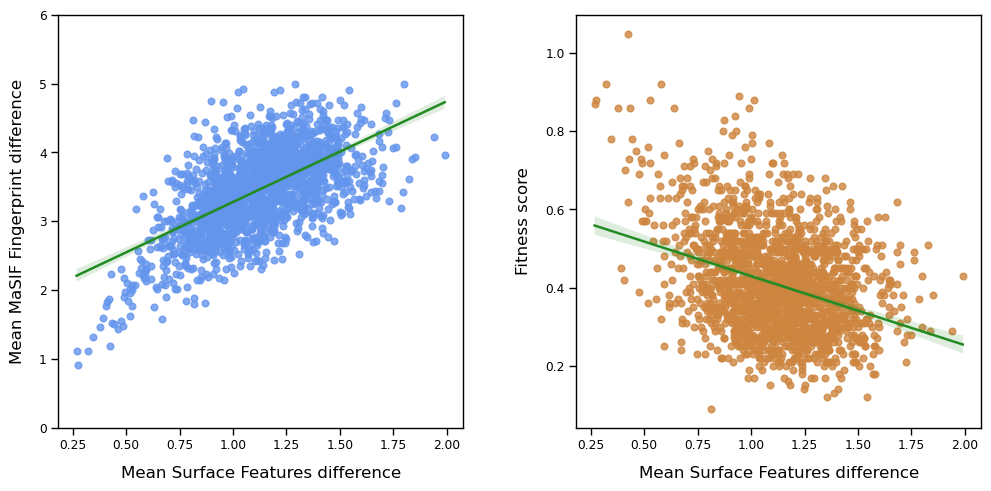

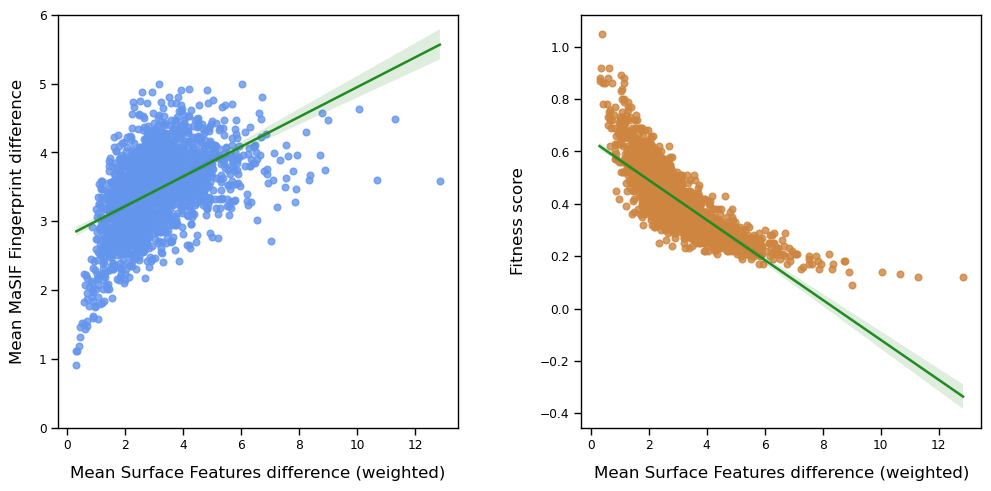

In [205]:
# plot the correlations
plot_input_feat_corr(df=df_input_all, ident="all_vs_all_asyn",     plots_out=asyn2asyn_plots_out, export=True, show=True, weighted=False)
plot_input_feat_corr(df=df_input_all, ident="all_vs_all_weighted", plots_out=asyn2asyn_plots_out, export=True, show=True, weighted=True)

#### 4.1.2 Plot MDS space

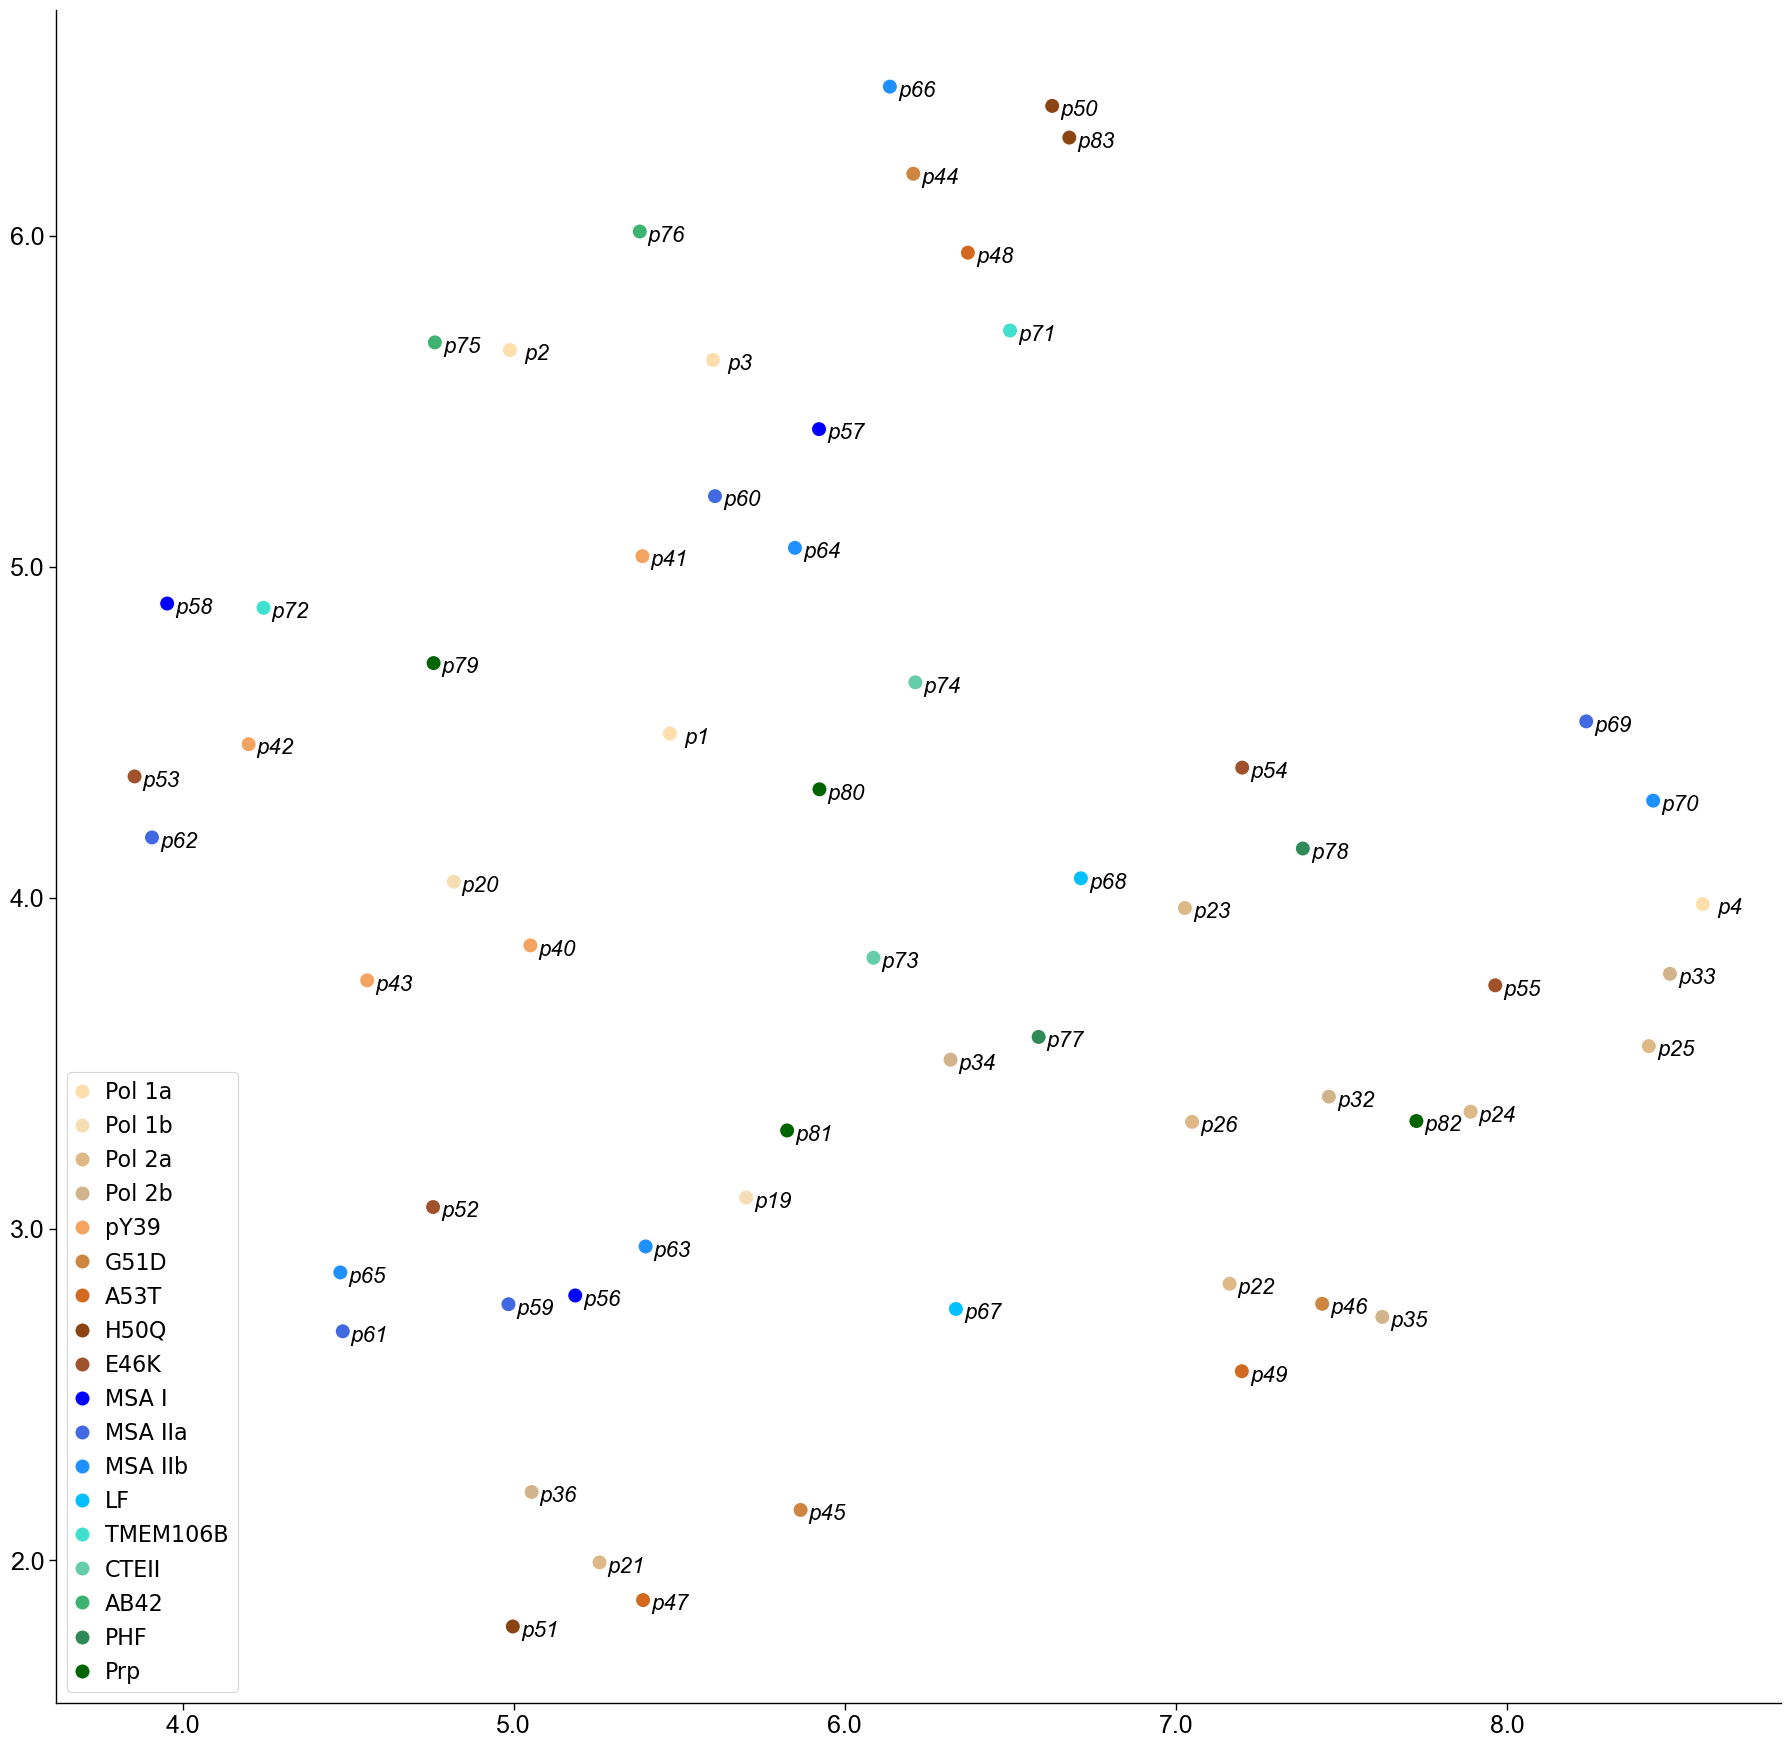

In [198]:
# plot unweighted difference
palette_full = [
    "#FFDEAD", "#F5DEB3", "#DEB887", "#D2B48C", "#F4A460", "#CD853F", "#D2691E", "#8B4513", "#A0522D",
    "#0000FF", "#4169E1", "#1E90FF", "#00BFFF", 
    "#40E0D0", "#66CDAA", "#3CB371", "#2E8B57", "#006400" 
           ]
plot_umap(to_plot=results, palette=palette_full,output=main_output, ident="all_pockets", export=True)

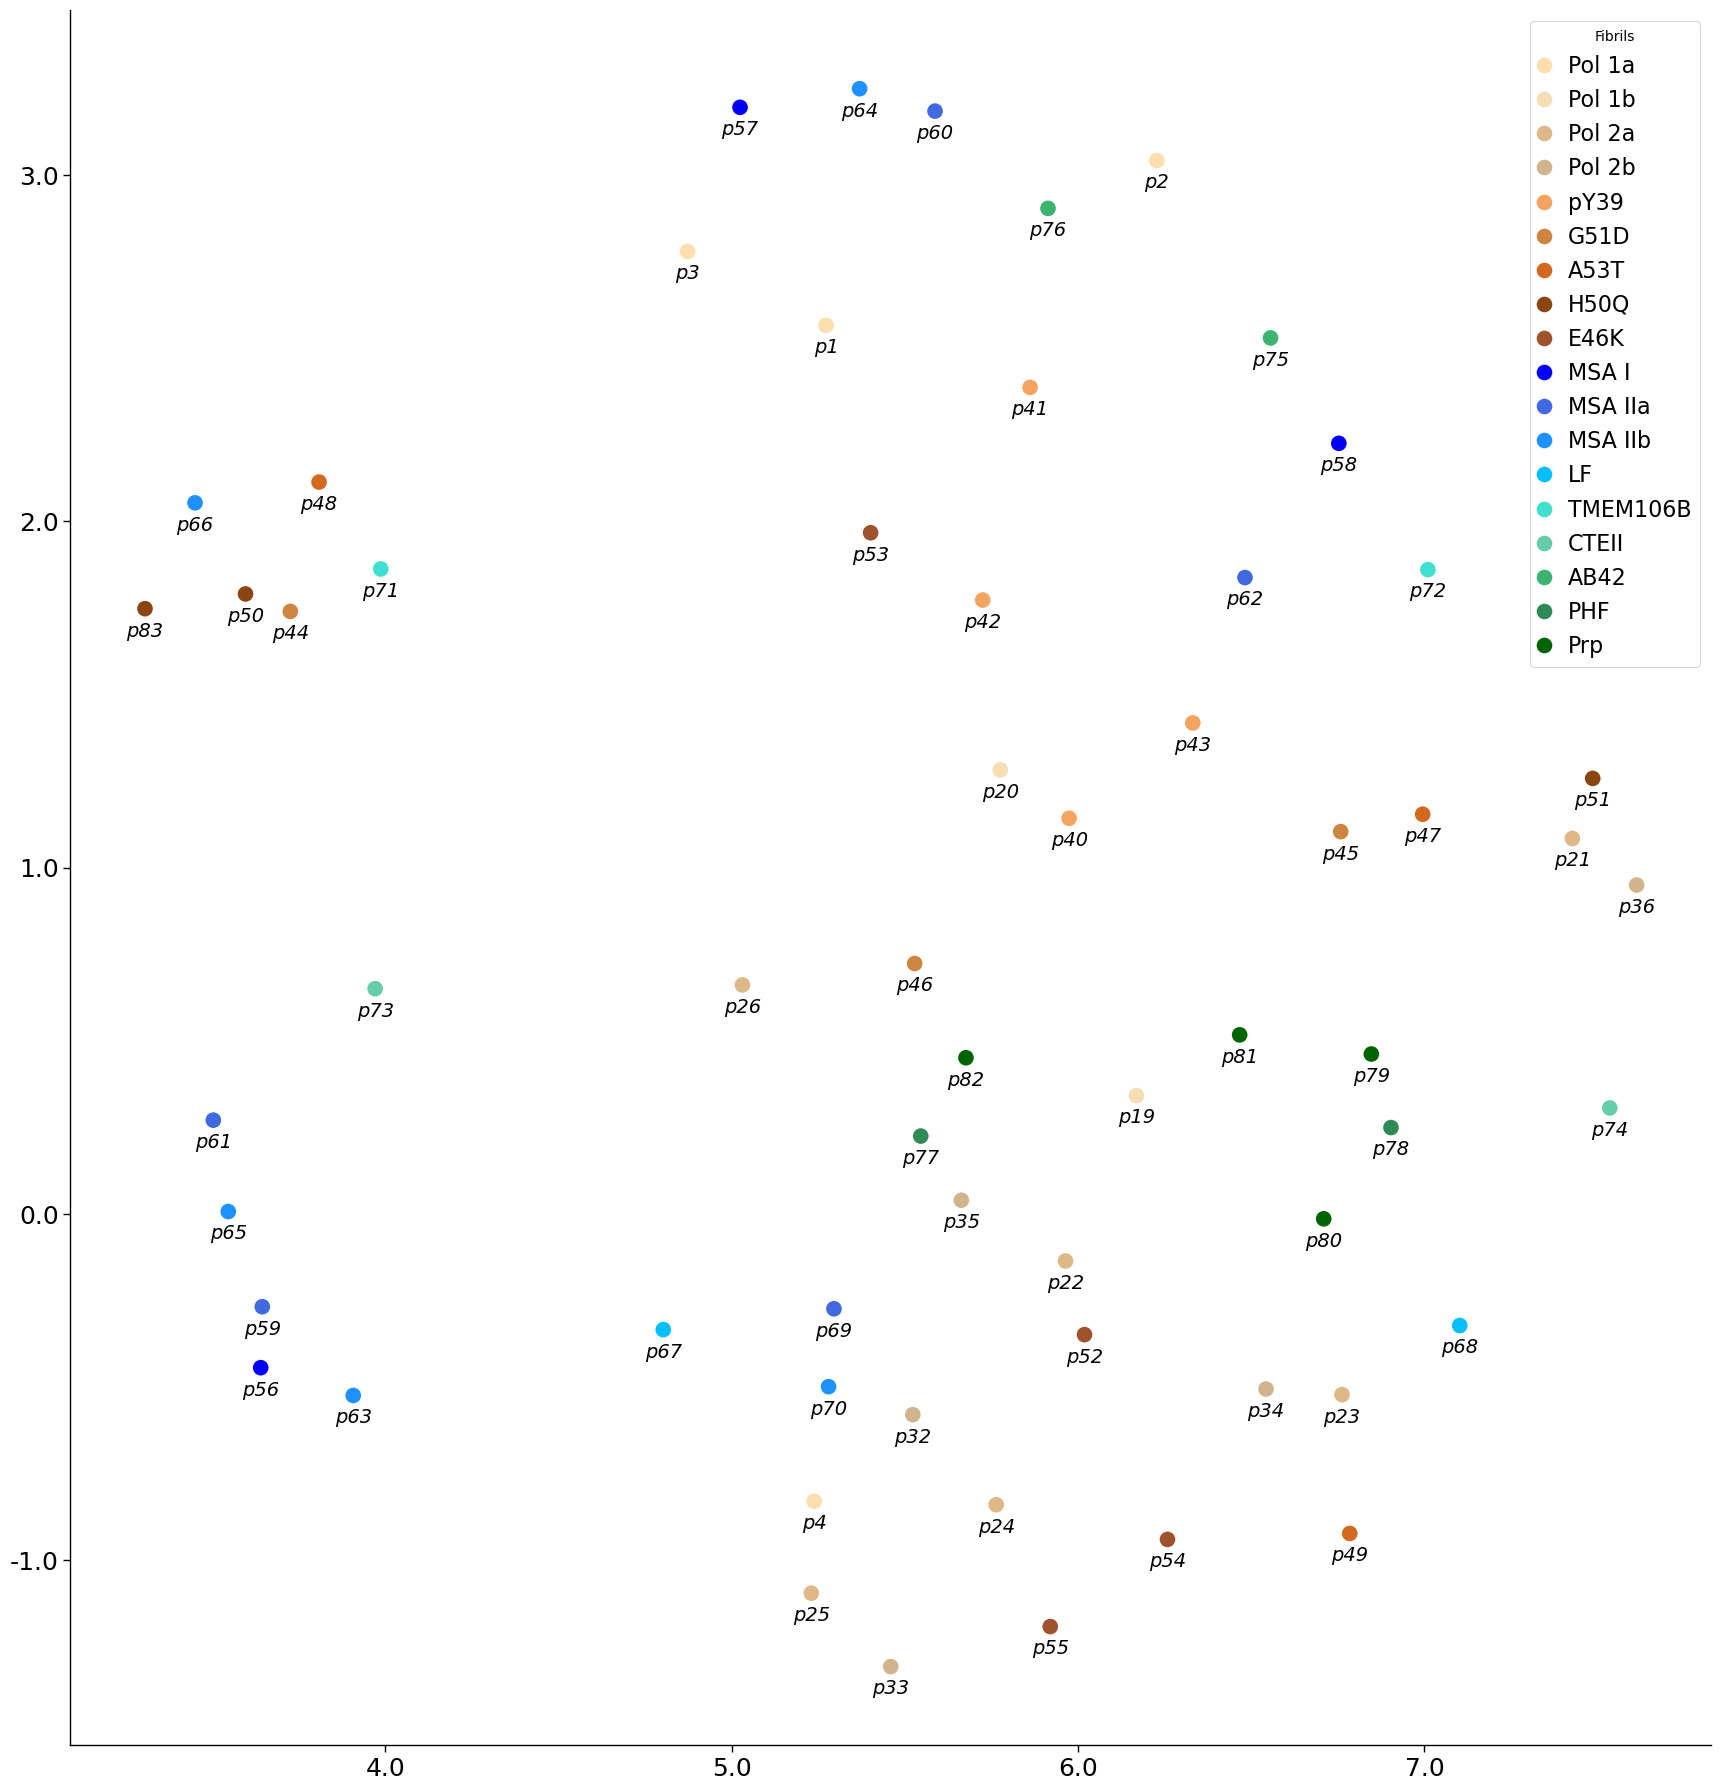

In [200]:
# plot weighted difference
to_plot = []
to_plot = copy.deepcopy(results_w)

palette = [
    "#FFDEAD", "#F5DEB3", "#DEB887", "#D2B48C", "#F4A460", "#CD853F", "#D2691E", "#8B4513", "#A0522D",
    "#0000FF", "#4169E1", "#1E90FF", "#00BFFF", 
    "#40E0D0", "#66CDAA", "#3CB371", "#2E8B57", "#006400" 
           ]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=[18,18])

sns.scatterplot(data=to_plot, x = 'projection_x', y = 'projection_y', hue='fibrils', s=150, legend=True, palette=palette)

axs.set_xlabel("")
axs.set_ylabel("")

yticks_loc = axs.get_yticks().tolist()
axs.yaxis.set_major_locator(mticker.FixedLocator(yticks_loc))
axs.set_yticklabels(labels=yticks_loc, fontsize=18, fontweight='book', fontfamily='sans')

xticks_loc = axs.get_xticks().tolist()
axs.xaxis.set_major_locator(mticker.FixedLocator(xticks_loc))
axs.set_xticklabels(labels=xticks_loc, fontsize=18, fontweight='book', fontfamily='sans')
    
axs.legend(title="Fibrils", title_fontsize=10,loc='upper right',  fontsize=16, markerscale=1., handlelength=0.5)

# annotate points
for p, x, y in zip(to_plot["pocket_name"], to_plot['projection_x'], to_plot['projection_y']):
    plt.annotate(text=p.replace('P', 'p'), xy=(x, y), xytext=(x, y-0.08), ha='center', 
                 fontsize=14, fontfamily='sans', fontstyle='oblique', fontweight='book')

# make the figure into a squae
plt.gca().set_aspect('equal', adjustable='box')

sns.set_context("paper")
sns.despine(trim=False)
plt.tight_layout()

plt.savefig(os.path.join(main_output, "all_pockets" + '_input_feats_weighted_umap.svg'), format='svg', dpi=300)
plt.savefig(os.path.join(main_output, "all_pockets" + '_input_feats_weighted_umap.pdf'), format='pdf', dpi=300)


#### 4.1.2 Plot Heatmaps

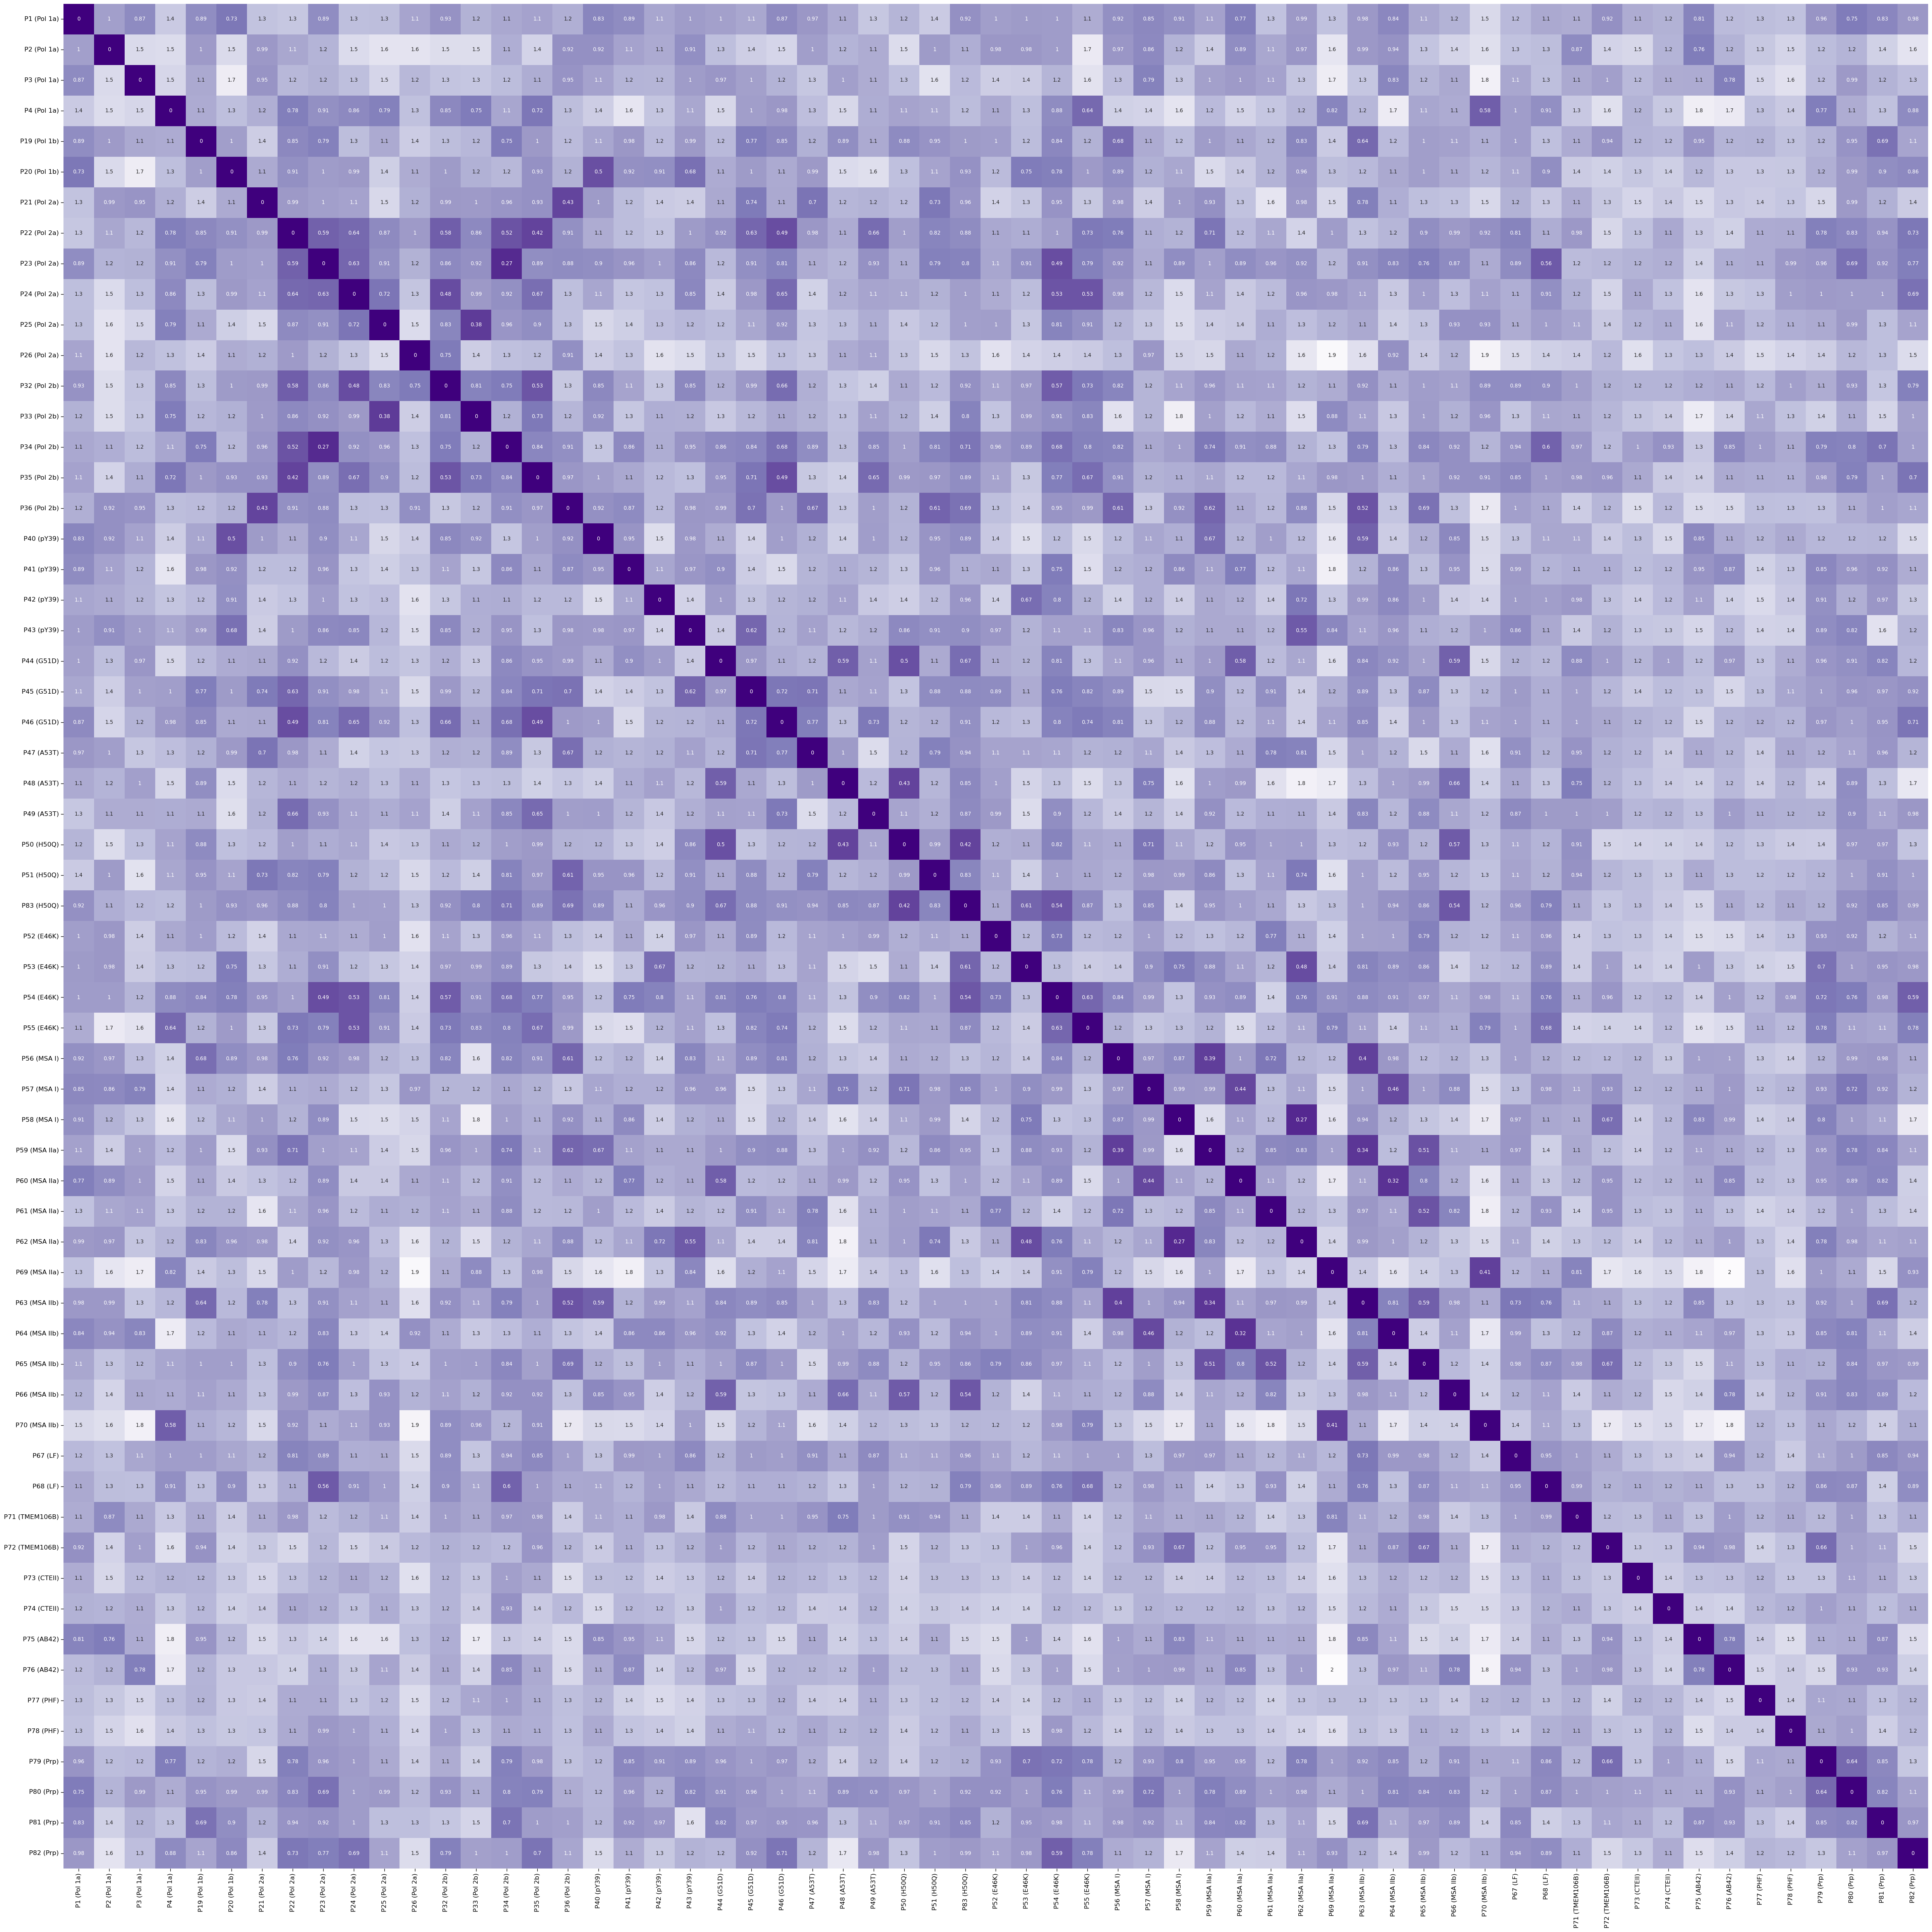

In [201]:
plot_heatmap(input_feat_diff_mat=input_feat_diff_mat, ident="all_vs_all", pockets=pockets, plots_out=main_output, export=True, show=True, figsize=[50,50], center=1.)

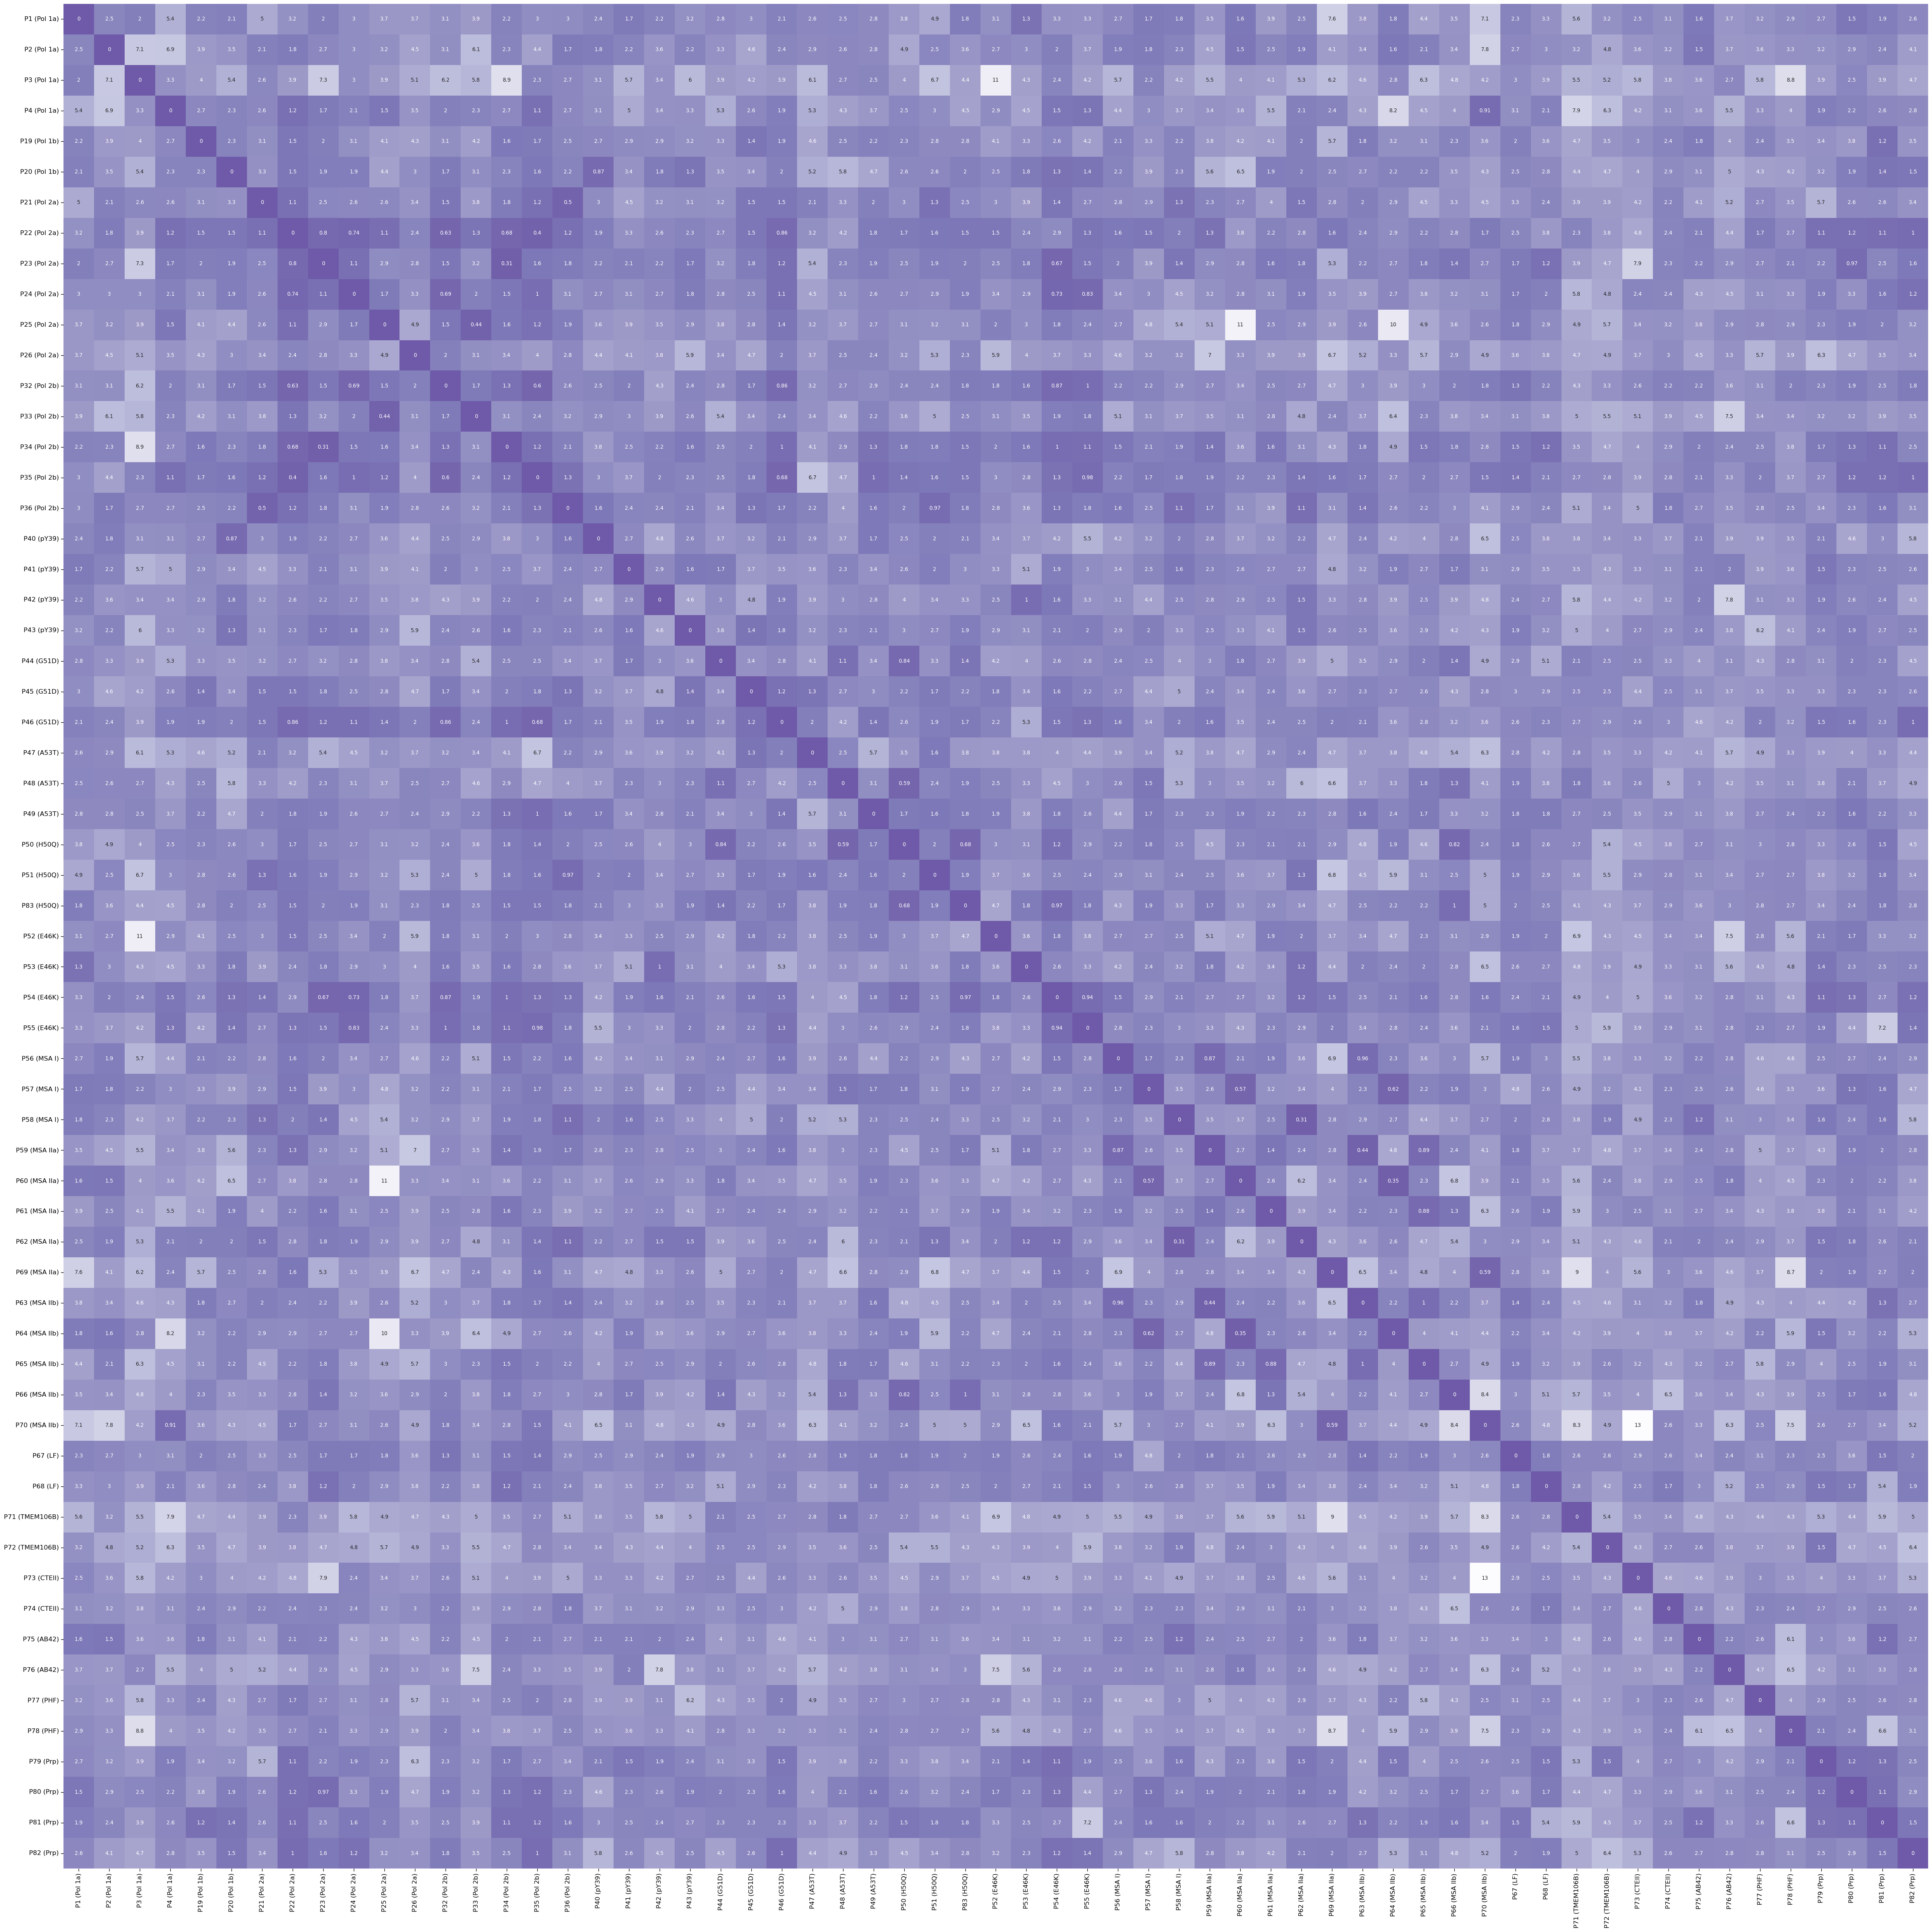

In [202]:
plot_heatmap(input_feat_diff_mat=input_feat_diff_mat_w, ident="all_vs_all_weighted", pockets=pockets, plots_out=main_output, export=True, show=True, figsize=[50,50], center=4)

In [203]:
# Find the all vs all matches
# container
allvsall_vessel = []

for poc in tqdm(pockets):
    df_temp = df_input_all.copy()[(df_input_all.source_pocket == poc) | (df_input_all.target_pocket == poc)].sort_values(by="icp_mean_input_diff", ascending=True).reset_index(drop=True).head(5)
    allvsall_vessel.append(df_temp)
    df_temp.to_csv(os.path.join(allvsall_out, poc + "_top5_nghs.csv"))

# put the selected nghs into a df
df_allvsall_sel_ngh = pd.concat(allvsall_vessel).reset_index(drop=True)
df_allvsall_sel_ngh.to_csv(os.path.join(allvsall_out, "allvsall_top5_nghs.csv"))

100%|██████████████████████████████████████████| 61/61 [00:00<00:00, 245.44it/s]


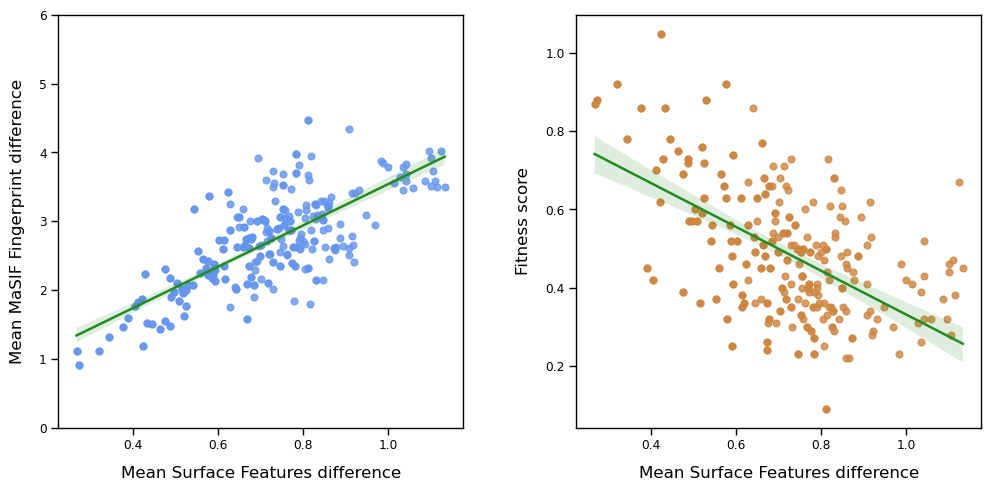

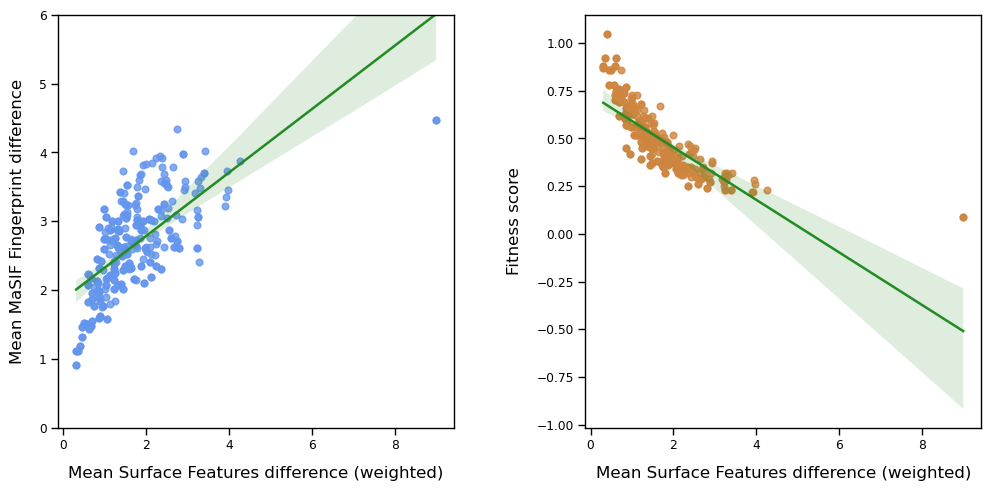

In [206]:
# plot the correlations
plot_input_feat_corr(df=df_allvsall_sel_ngh, ident="all_vs_all_selected_nghs",           plots_out=allvsall_plots_out, export=True, show=True, weighted=False)
plot_input_feat_corr(df=df_allvsall_sel_ngh, ident="all_vs_all_selected_nghs_weighted",  plots_out=allvsall_plots_out, export=True, show=True, weighted=True)

### 4.2 Compare the aSyn Brain structures to themselves

In [207]:
# get the pocket names in the brain derived structures
asyn_brain_pockets = [p for p in pockets if p.split("_")[0] in ["MSA", "LF"]]


# get the information for the brain derived pockets
df_input_b2b = df_input_all.copy()[(df_input_all.source_pocket.isin(asyn_brain_pockets)) & (df_input_all.target_pocket.isin(asyn_brain_pockets))].sort_values(by='combined_fitness_score', ascending=0).reset_index(drop=1)

# export all aSyn brain pockets matches
df_input_b2b.to_csv(os.path.join(asyn2asyn_out, 'all_asyn_brain_to_asyn_brain_matches.csv'))

print(df_input_all.shape)
print(df_input_b2b.shape)

df_input_b2b.head(2)

(1830, 17)
(105, 17)


pocket_matches                            pocket_pairs  \
0  (MSA_IIa_P60, MSA_IIb_P64)  [MSA_IIb_P64, aSyn, MSA_IIa_P60, aSyn]   
1    (MSA_IIa_P62, MSA_I_P58)    [MSA_IIa_P62, aSyn, MSA_I_P58, aSyn]   

  source_pocket target_pocket  icp_mean_MaSIF_diff  icp_rmse  \
0   MSA_IIb_P64   MSA_IIa_P60             1.113781  0.615505   
1   MSA_IIa_P62     MSA_I_P58             1.116053  0.589014   

   icp_fitness_source  icp_fitness_target  combined_fitness_score  \
0            0.877005                0.92                    0.92   
1            0.790419                0.87                    0.87   

   icp_nb_corres  icp_mean_input_diff  icp_mean_input_diff_weighted  \
0            164             0.319574                      0.347363   
1            132             0.267585                      0.307569   

   size_source  size_target  src2target_size_ratio source_pocket_fibril  \
0          187          179                   1.04                 aSyn   
1          167          151                   1.11                 aSyn   

  target_pocket_fibril  
0                 aSyn  
1                 aSyn

In [208]:
# plot the MDS space of the aSyn Brain to Brain comparison
results_b2b   = results[results.pockets.isin(asyn_brain_pockets)].reset_index(drop=True)
results_b2b_w = results_w[results_w.pockets.isin(asyn_brain_pockets)].reset_index(drop=True)
results_b2b

pockets  projection_x  projection_y  fibrils pocket_name
0     MSA_I_P56      5.186027      2.799342    MSA I         P56
1     MSA_I_P57      5.922372      5.416021    MSA I         P57
2     MSA_I_P58      3.953455      4.889240    MSA I         P58
3   MSA_IIa_P59      4.984334      2.772884  MSA IIa         P59
4   MSA_IIa_P60      5.608054      5.213574  MSA IIa         P60
5   MSA_IIa_P61      4.483808      2.691075  MSA IIa         P61
6   MSA_IIa_P62      3.907691      4.182761  MSA IIa         P62
7   MSA_IIb_P63      5.398573      2.947387  MSA IIb         P63
8   MSA_IIb_P64      5.849528      5.057410  MSA IIb         P64
9   MSA_IIb_P65      4.476524      2.868949  MSA IIb         P65
10  MSA_IIb_P66      6.136278      6.450496  MSA IIb         P66
11       LF_P67      6.335655      2.758571       LF         P67
12       LF_P68      6.713177      4.059321       LF         P68
13  MSA_IIa_P69      8.239567      4.533309  MSA IIa         P69
14  MSA_IIb_P70      8.441746      4.293881  MSA IIb         P70

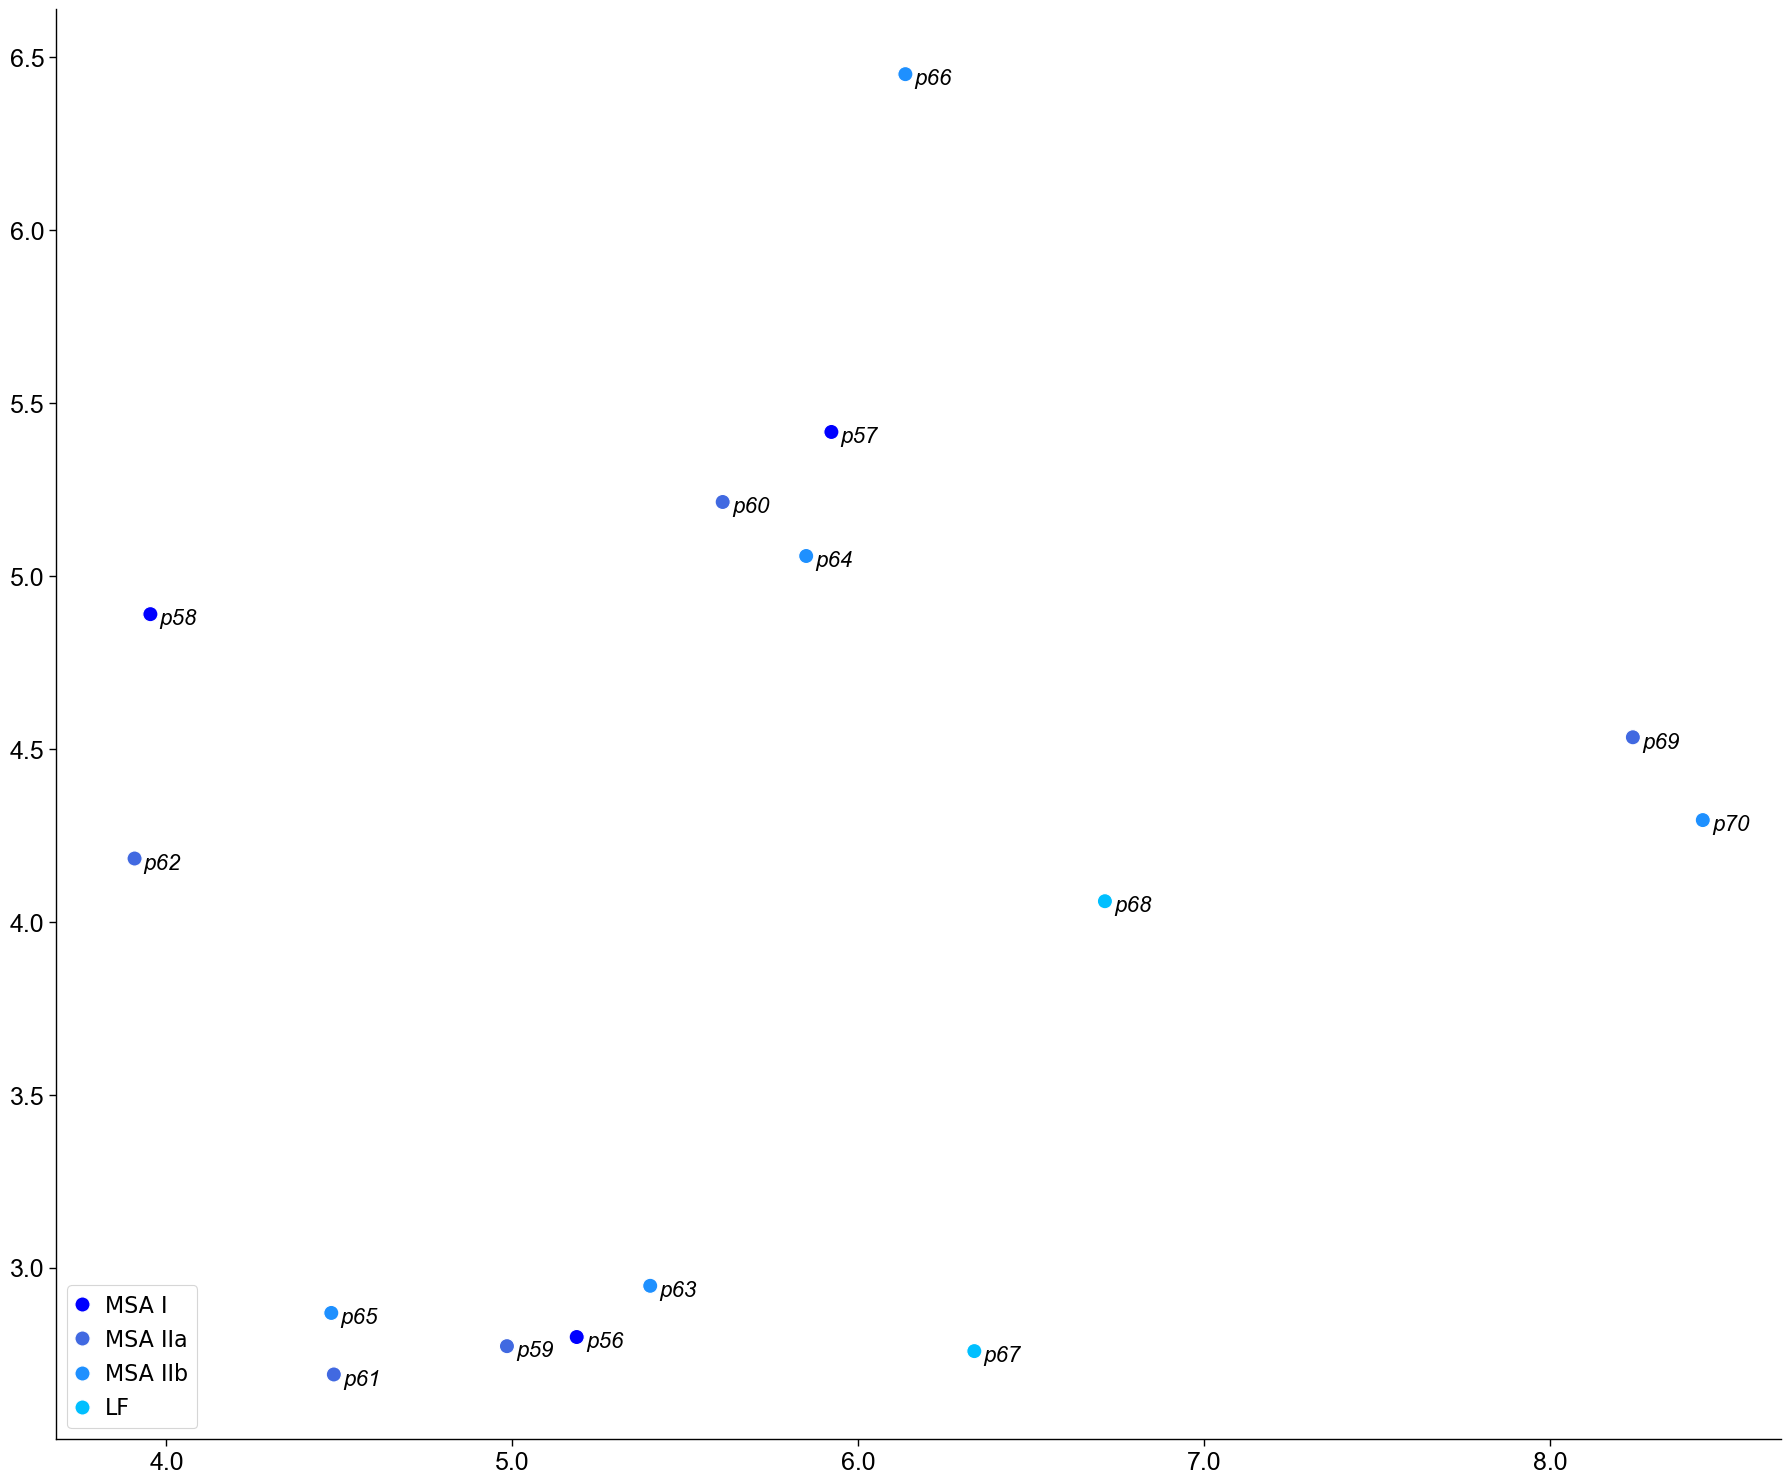

In [209]:
# plot unweighted difference
palette01 = [
    "#0000FF", "#4169E1", "#1E90FF", "#00BFFF", 
           ]
plot_umap(
    to_plot=results_b2b, 
    palette=palette01,
    output=asyn2asyn_plots_out, 
    ident="aSyn_brain_to_brain", 
    export=True
    )

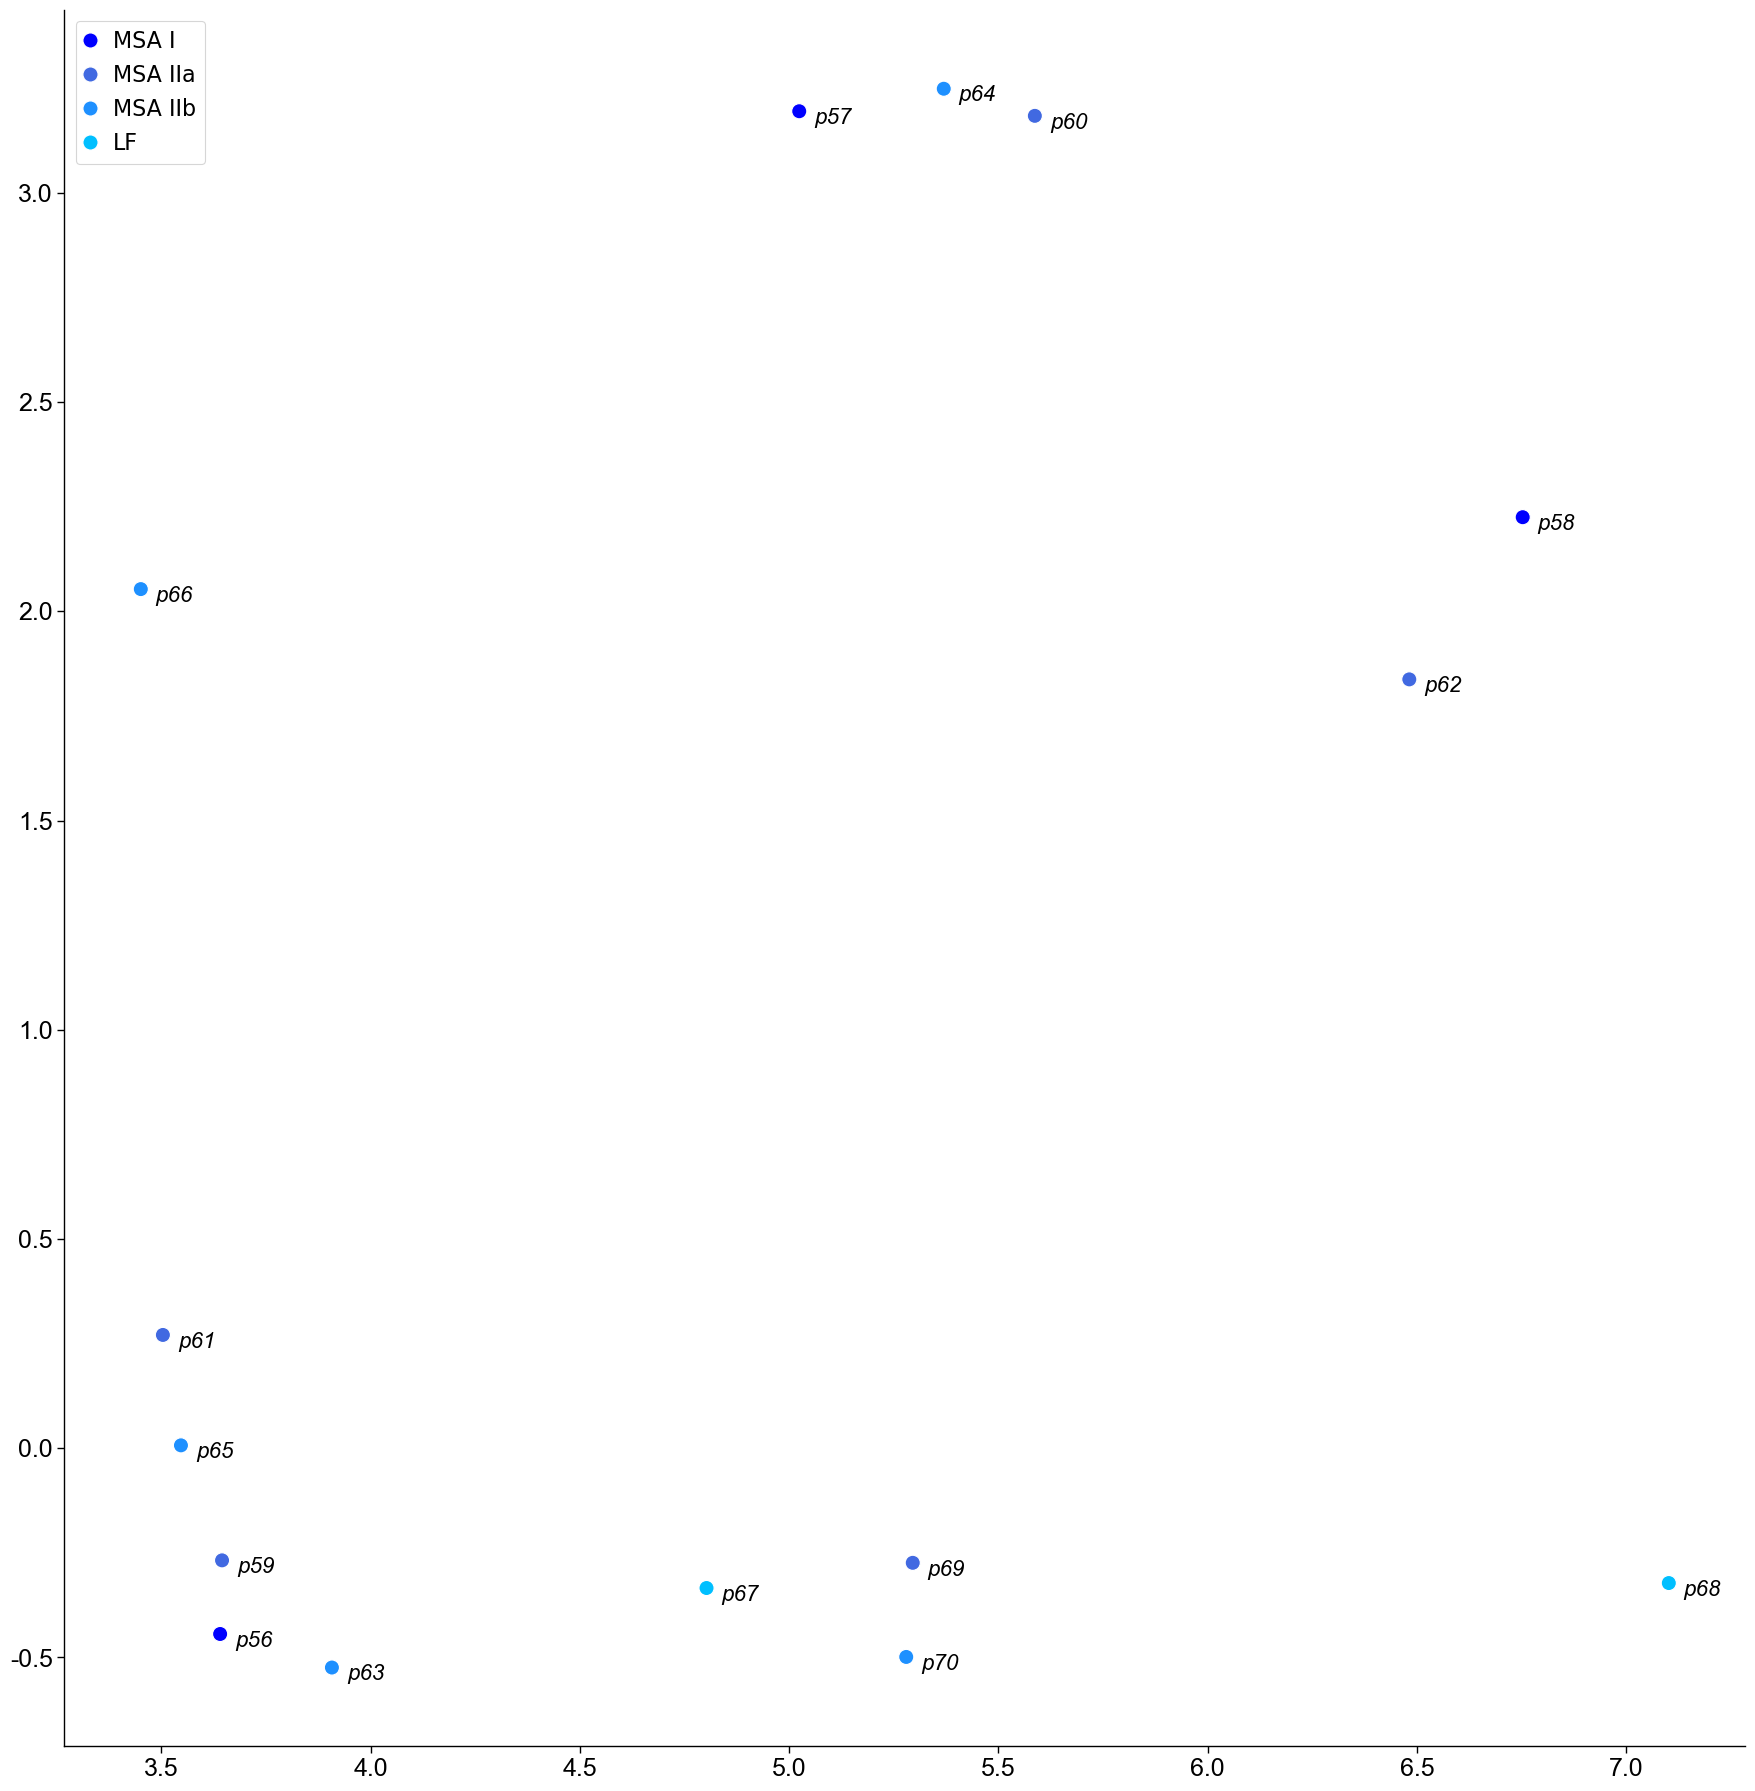

In [242]:
# plot weighted difference
to_plot = copy.deepcopy(results_b2b_w)

palette = [
    "#0000FF", "#4169E1", "#1E90FF", "#00BFFF", 
           ]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=[18,18])

sns.scatterplot(data=to_plot, x = 'projection_x', y = 'projection_y', hue='fibrils', s=120, legend=True, palette=palette)
    
axs.set_xlabel("")
axs.set_ylabel("")

yticks_loc = axs.get_yticks().tolist()
axs.yaxis.set_major_locator(mticker.FixedLocator(yticks_loc))
axs.set_yticklabels(labels=yticks_loc, fontsize=18, fontweight='book', fontfamily='arial')

xticks_loc = axs.get_xticks().tolist()
axs.xaxis.set_major_locator(mticker.FixedLocator(xticks_loc))
axs.set_xticklabels(labels=xticks_loc, fontsize=18, fontweight='book', fontfamily='arial')
    
axs.legend(title="", title_fontsize=10, loc='upper left',  fontsize=16, markerscale=1., handlelength=0.5)

# annotate points
for p, x, y in zip(to_plot["pocket_name"], to_plot['projection_x'], to_plot['projection_y']):
    plt.annotate(text=p.replace('P', 'p'), xy=(x, y), xytext=(x+0.08, y-0.03), ha='center', 
                fontsize=16, fontfamily='arial', fontstyle='oblique', fontweight='book')

# make the figure into a square
plt.gca().set_aspect('equal', adjustable='box')

sns.set_context("paper")
sns.despine(trim=False)
plt.tight_layout()

plt.savefig(os.path.join(asyn2asyn_plots_out, "aSyn_brain_to_brain" + '_input_feats_umap_weighted.svg'), format='svg', dpi=300)
plt.savefig(os.path.join(asyn2asyn_plots_out, "aSyn_brain_to_brain" + '_input_feats_umap_weighted.pdf'), format='pdf', dpi=300)

#### I need to get the closest matches among the MDS space for plotting later 
- I will go through each pocket and get its matches and find the closest 5 neighbours

In [214]:
# container
b2b_vessel = []

for poc00 in tqdm(asyn_brain_pockets):
    df_temp00 = df_input_b2b.copy()[(df_input_b2b.source_pocket == poc00) | (df_input_b2b.target_pocket == poc00)].sort_values(by="icp_mean_input_diff", ascending=True).reset_index(drop=True).head(5)
    b2b_vessel.append(df_temp00)
    df_temp00.to_csv(os.path.join(asyn2asyn_out, poc00 + "_top5_nghs.csv"))

# put the selected nghs into a df
df_b2b_sel_ngh = pd.concat(b2b_vessel).reset_index(drop=True)
df_b2b_sel_ngh.to_csv(os.path.join(asyn2asyn_out, "asyn_brain_to_brain_top5_nghs.csv"))

100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 370.98it/s]


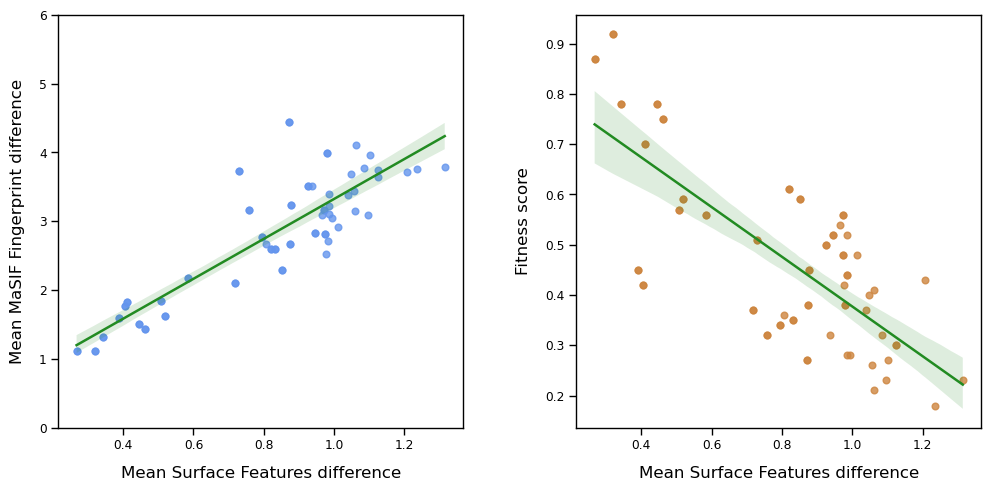

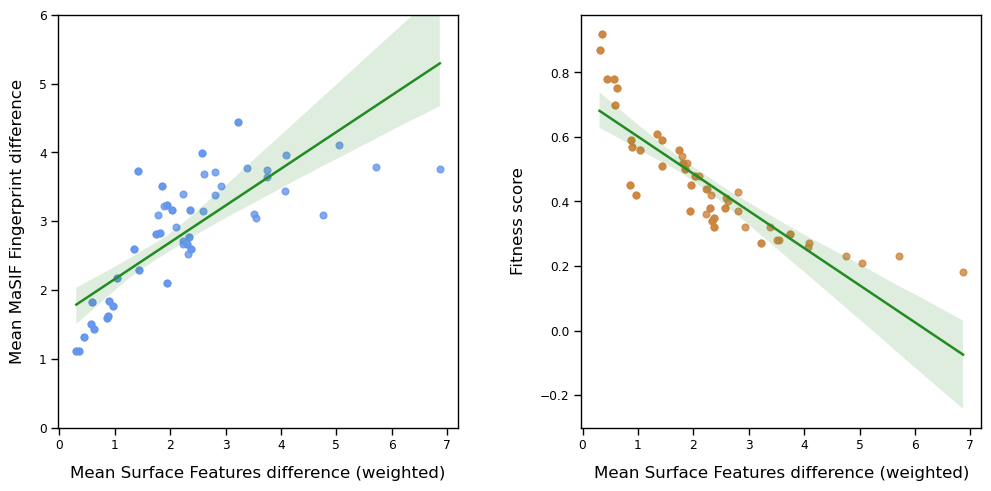

In [215]:
# plot the correlations
plot_input_feat_corr(df=df_b2b_sel_ngh, ident="asyn_brain_vs_brain_asyn_selected_nghs",  plots_out=asyn2asyn_plots_out, export=True, show=True, weighted=False)
plot_input_feat_corr(df=df_b2b_sel_ngh, ident="asyn_brain_vs_brain_asyn_selected_nghs_weighted",  plots_out=asyn2asyn_plots_out, export=True, show=True, weighted=True)

### 4.3 Compare the aSyn Brain structures to other amyloid fibrils (not aSyn)

In [216]:
# get the pocket names in the brain derived structures
asyn_brain_and_other_amyloids_pockets = [p for p in pockets if p.split("_")[0] not in ['A53T', 'Pol', 'G51D', 'E46K', 'H50Q', 'pY39']]

# get the information for the desired pockets
df_input_b2others = df_input_all.copy()[
    (df_input_all.source_pocket.isin(asyn_brain_and_other_amyloids_pockets)) & 
    (df_input_all.target_pocket.isin(asyn_brain_and_other_amyloids_pockets))
    ].sort_values(by='combined_fitness_score', ascending=0).reset_index(drop=1)

# export all aSyn brain pockets matches
df_input_b2others.to_csv(os.path.join(asyn2others_out, 'all_asyn_brain_to_other_amyloids_matches.csv'))

print(df_input_all.shape)
print(df_input_b2others.shape)

df_input_b2others.head(2)

(1830, 17)
(351, 17)


pocket_matches                            pocket_pairs  \
0  (MSA_IIa_P60, MSA_IIb_P64)  [MSA_IIb_P64, aSyn, MSA_IIa_P60, aSyn]   
1    (MSA_IIa_P62, MSA_I_P58)    [MSA_IIa_P62, aSyn, MSA_I_P58, aSyn]   

  source_pocket target_pocket  icp_mean_MaSIF_diff  icp_rmse  \
0   MSA_IIb_P64   MSA_IIa_P60             1.113781  0.615505   
1   MSA_IIa_P62     MSA_I_P58             1.116053  0.589014   

   icp_fitness_source  icp_fitness_target  combined_fitness_score  \
0            0.877005                0.92                    0.92   
1            0.790419                0.87                    0.87   

   icp_nb_corres  icp_mean_input_diff  icp_mean_input_diff_weighted  \
0            164             0.319574                      0.347363   
1            132             0.267585                      0.307569   

   size_source  size_target  src2target_size_ratio source_pocket_fibril  \
0          187          179                   1.04                 aSyn   
1          167          151                   1.11                 aSyn   

  target_pocket_fibril  
0                 aSyn  
1                 aSyn

In [217]:
# plot the MDS space of the aSyn Brain to other amyloids comparison
results_b2o   = results[results.pockets.isin(asyn_brain_and_other_amyloids_pockets)].reset_index(drop=True)
results_b2o_w = results_w[results_w.pockets.isin(asyn_brain_and_other_amyloids_pockets)].reset_index(drop=True)
results_b2o.head()

pockets  projection_x  projection_y  fibrils pocket_name
0    MSA_I_P56      5.186027      2.799342    MSA I         P56
1    MSA_I_P57      5.922372      5.416021    MSA I         P57
2    MSA_I_P58      3.953455      4.889240    MSA I         P58
3  MSA_IIa_P59      4.984334      2.772884  MSA IIa         P59
4  MSA_IIa_P60      5.608054      5.213574  MSA IIa         P60

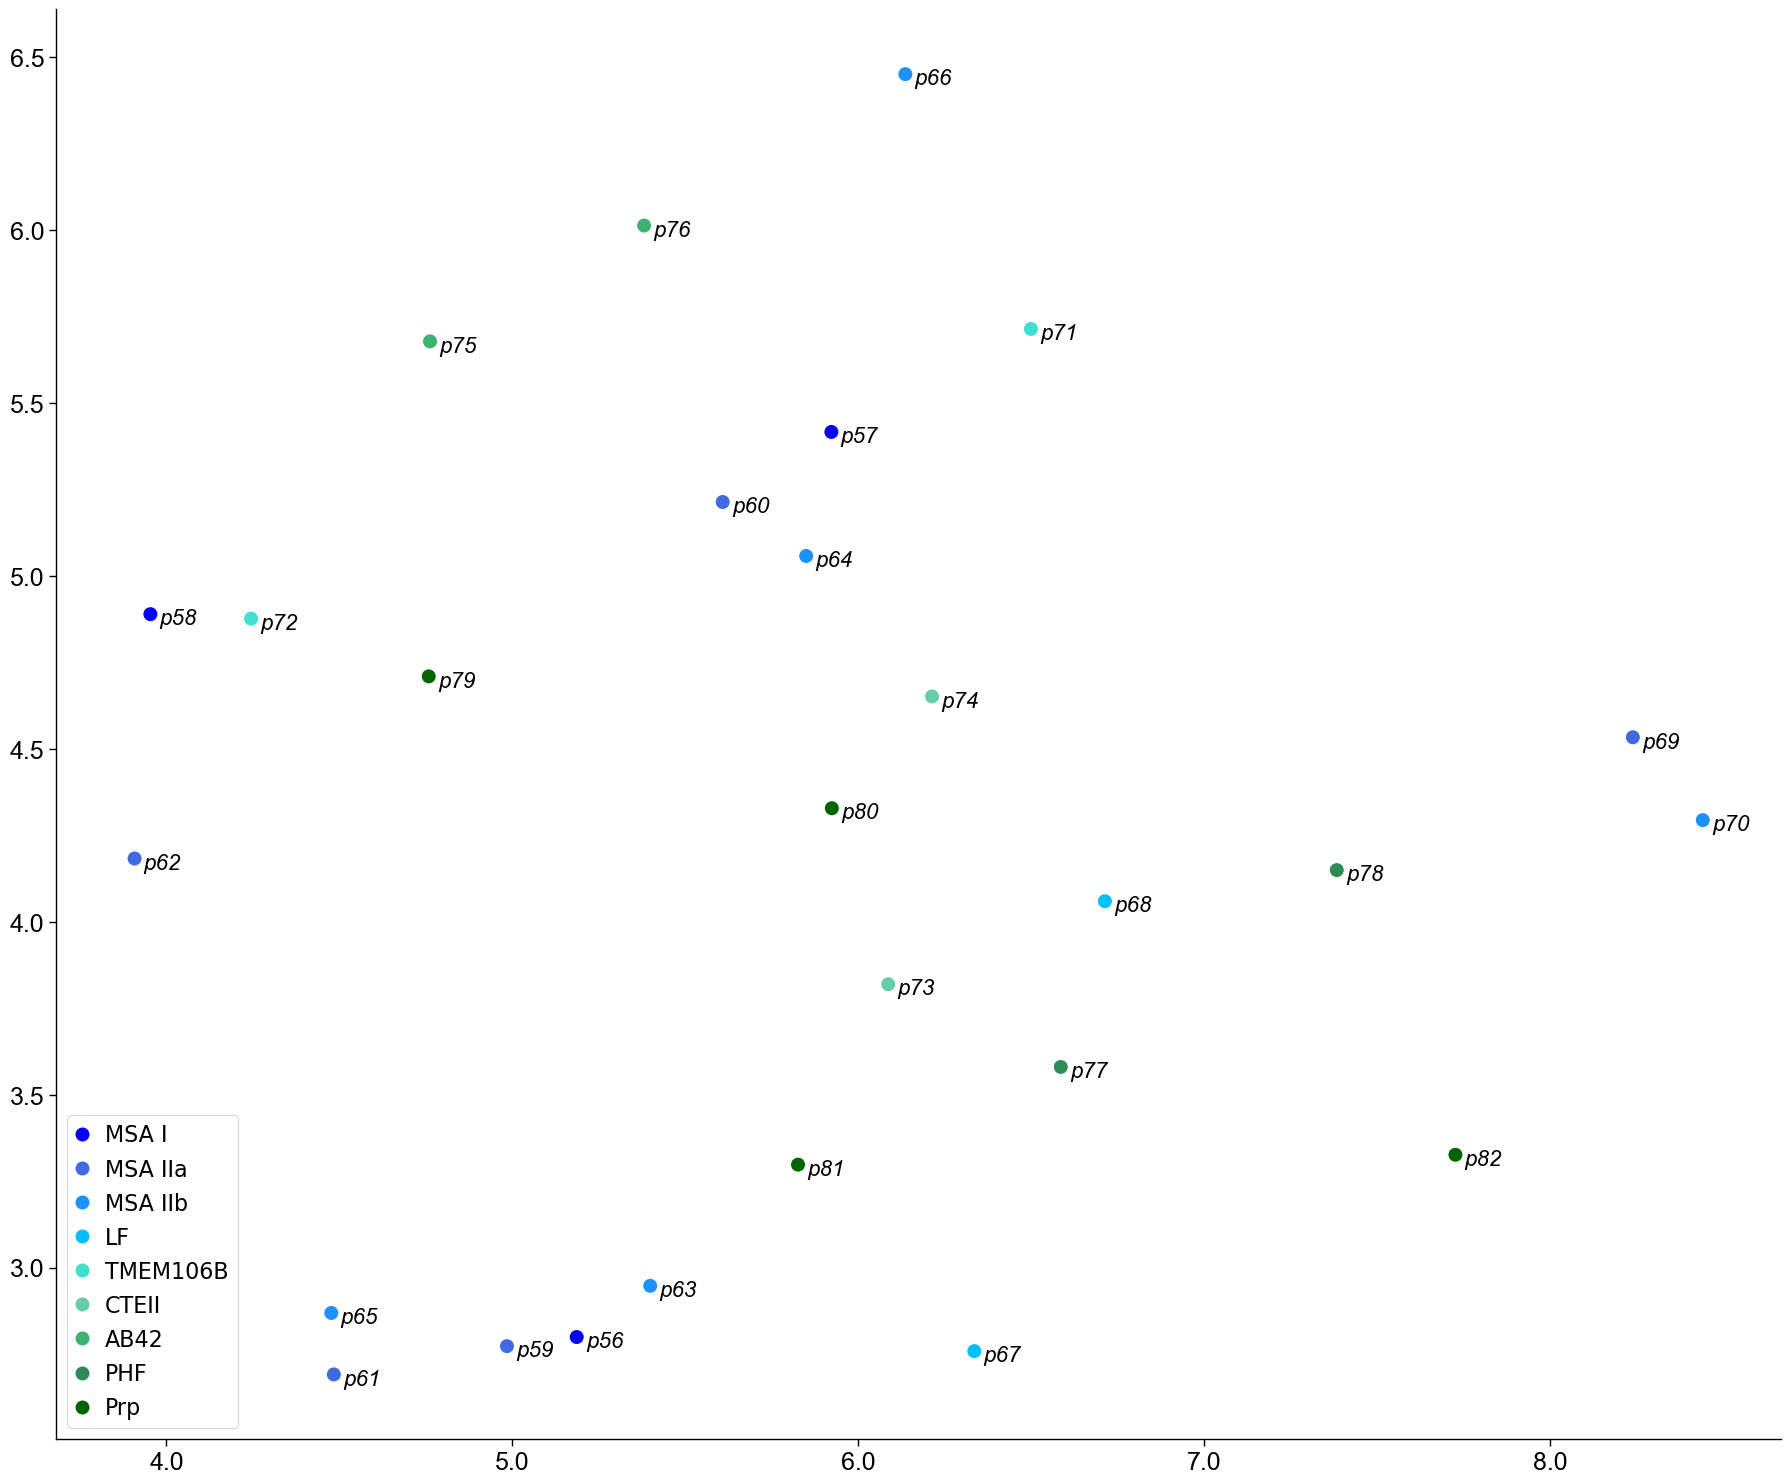

In [219]:
# plot unweighted difference
palette02 = [
    "#0000FF", "#4169E1", "#1E90FF", "#00BFFF", 
    "#40E0D0", "#66CDAA", "#3CB371", "#2E8B57", "#006400"
           ]
plot_umap(
    to_plot=results_b2o, 
    palette=palette02, 
    output=asyn2others_plots_out, 
    ident="aSyn_brain_to_other_amyloids", 
    export=1
    )

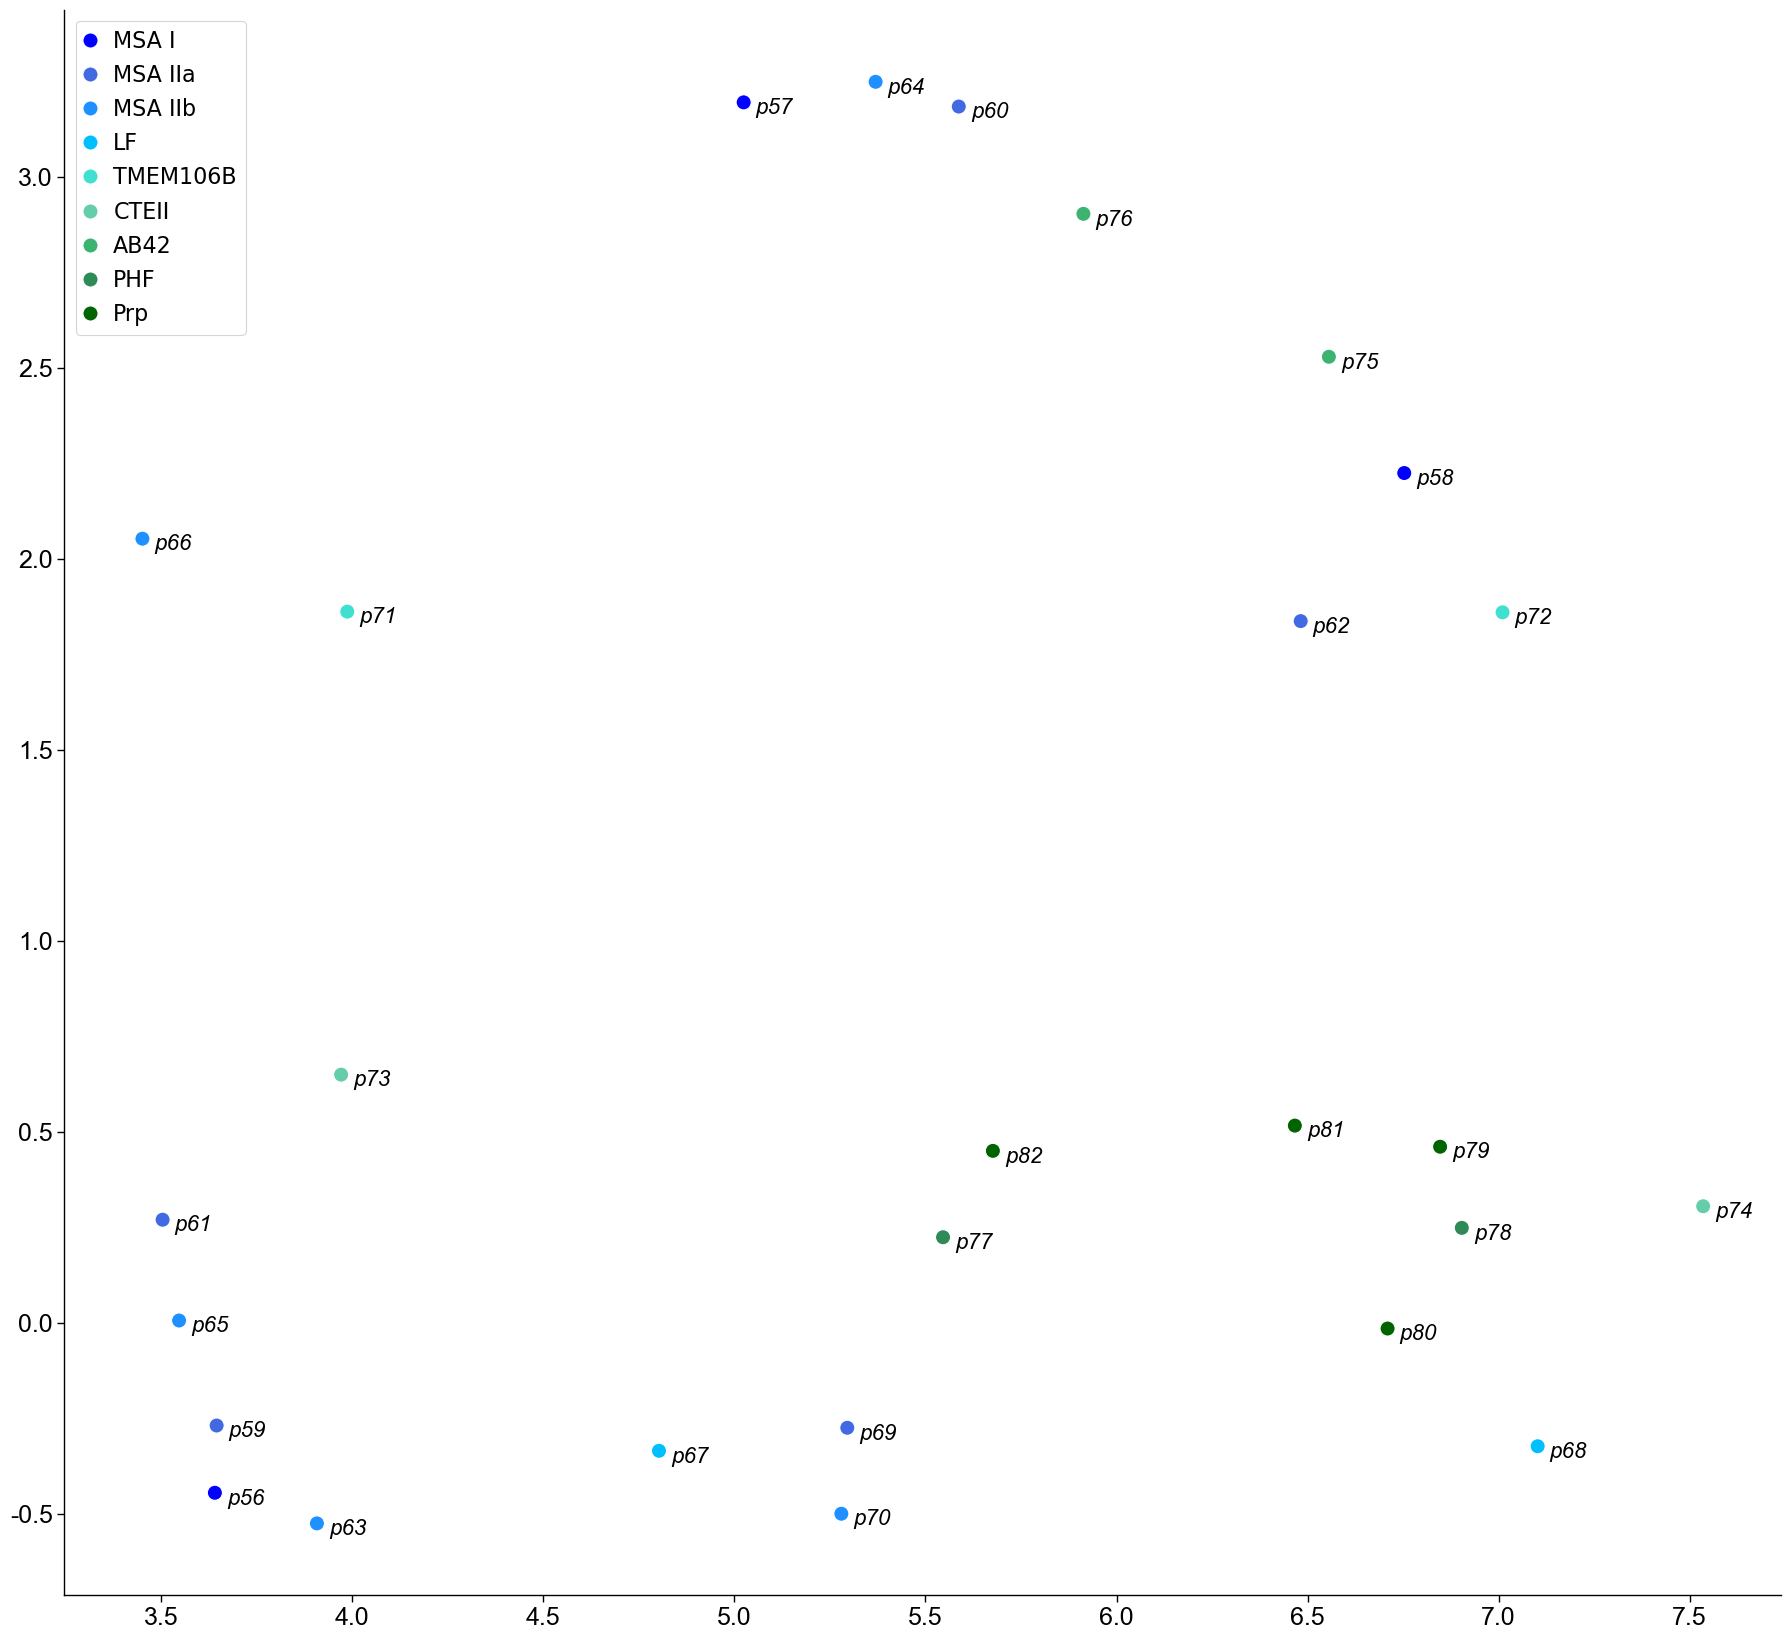

In [244]:
# plot weighted difference
to_plot = copy.deepcopy(results_b2o_w)

palette = [
    "#0000FF", "#4169E1", "#1E90FF", "#00BFFF", 
    "#40E0D0", "#66CDAA", "#3CB371", "#2E8B57", "#006400"
           ]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=[18,18])

sns.scatterplot(data=to_plot, x = 'projection_x', y = 'projection_y', hue='fibrils', s=120, legend=True, palette=palette)
    
axs.set_xlabel("")
axs.set_ylabel("")

yticks_loc = axs.get_yticks().tolist()
axs.yaxis.set_major_locator(mticker.FixedLocator(yticks_loc))
axs.set_yticklabels(labels=yticks_loc, fontsize=18, fontweight='book', fontfamily='arial')

xticks_loc = axs.get_xticks().tolist()
axs.xaxis.set_major_locator(mticker.FixedLocator(xticks_loc))
axs.set_xticklabels(labels=xticks_loc, fontsize=18, fontweight='book', fontfamily='arial')
    
axs.legend(title="", title_fontsize=10, loc='upper left',  fontsize=16, markerscale=1., handlelength=0.5)

# annotate points
for p, x, y in zip(to_plot["pocket_name"], to_plot['projection_x'], to_plot['projection_y']):
    plt.annotate(text=p.replace('P', 'p'), xy=(x, y), xytext=(x+0.08, y-0.03), ha='center', 
                fontsize=16, fontfamily='arial', fontstyle='oblique', fontweight='book')

# make the figure into a squae
plt.gca().set_aspect('equal', adjustable='box')

sns.set_context("paper")
sns.despine(trim=False)
plt.tight_layout()

plt.savefig(os.path.join(asyn2others_plots_out, "aSyn_brain_to_other_amyloids" + '_input_feats_umap_weighted.svg'), format='svg', dpi=300)
plt.savefig(os.path.join(asyn2others_plots_out, "aSyn_brain_to_other_amyloids" + '_input_feats_umap_weighted.pdf'), format='pdf', dpi=300)


In [226]:
# container
b2o_vessel = []

for poc01 in tqdm(asyn_brain_and_other_amyloids_pockets):
    df_temp01 = df_input_b2others.copy()[(df_input_b2others.source_pocket == poc01) | (df_input_b2others.target_pocket == poc01)].sort_values(by="icp_mean_input_diff", ascending=True).reset_index(drop=True).head(5)
    b2o_vessel.append(df_temp01)
    df_temp01.to_csv(os.path.join(asyn2others_out, poc01 + "_top5_nghs.csv"))

# put the selected nghs into a df
df_b2o_sel_ngh = pd.concat(b2o_vessel).reset_index(drop=True)
df_b2o_sel_ngh.to_csv(os.path.join(asyn2others_out, "asyn_brain_to_other_amyloids_top5_nghs.csv"))

100%|██████████████████████████████████████████| 27/27 [00:00<00:00, 258.97it/s]


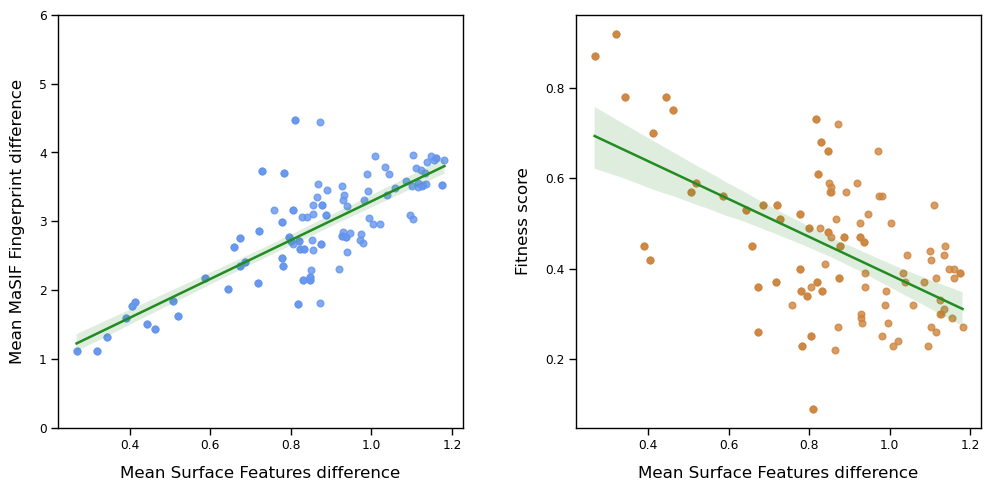

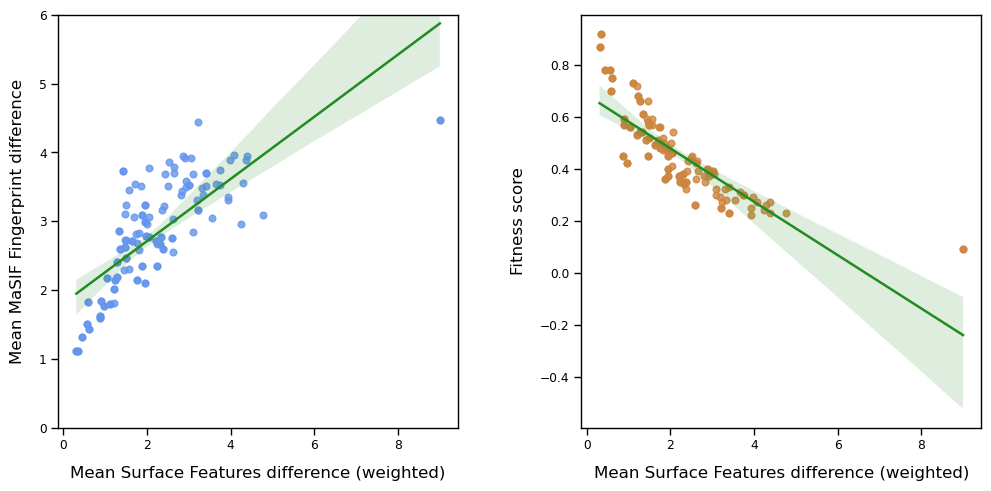

In [227]:
# plot the correlations
plot_input_feat_corr(df=df_b2o_sel_ngh, ident="asyn_brain_vs_other_amyloids_selected_nghs",           plots_out=asyn2others_plots_out, export=True, show=True, weighted=False)
plot_input_feat_corr(df=df_b2o_sel_ngh, ident="asyn_brain_vs_other_amyloids_selected_nghs_weighted",  plots_out=asyn2others_plots_out, export=True, show=True, weighted=True)

### 4.4 Compare the aSyn Brain structures to In vitro generated aSyn fibrils

In [228]:
# get the pocket names
asyn_brain_and_other_invitro_pockets = [p for p in pockets if p.split("_")[0] in ['MSA', 'LF', 'A53T', 'Pol', 'G51D', 'E46K', 'H50Q', 'pY39']]

# get the information for the desired pockets
df_input_b2invitro = df_input_all.copy()[
    (df_input_all.source_pocket.isin(asyn_brain_and_other_invitro_pockets)) & 
    (df_input_all.target_pocket.isin(asyn_brain_and_other_invitro_pockets))
    ].sort_values(by='combined_fitness_score', ascending=0).reset_index(drop=1)

# export all aSyn brain pockets matches
df_input_b2invitro.to_csv(os.path.join(asyn2invitro_out, 'all_asyn_brain_to_invitro_matches.csv'))

print(df_input_all.shape)
print(df_input_b2invitro.shape)

df_input_b2invitro.head(2)

(1830, 17)
(1176, 17)


pocket_matches                          pocket_pairs  \
0  (Pol_2a_P22, Pol_2b_P35)  [Pol_2b_P35, aSyn, Pol_2a_P22, aSyn]   
1  (Pol_2a_P22, Pol_2b_P32)  [Pol_2a_P22, aSyn, Pol_2b_P32, aSyn]   

  source_pocket target_pocket  icp_mean_MaSIF_diff  icp_rmse  \
0    Pol_2b_P35    Pol_2a_P22             1.184599  0.648768   
1    Pol_2a_P22    Pol_2b_P32             2.213575  0.647479   

   icp_fitness_source  icp_fitness_target  combined_fitness_score  \
0            0.854015                1.05                    1.05   
1            0.918919                0.22                    0.92   

   icp_nb_corres  icp_mean_input_diff  icp_mean_input_diff_weighted  \
0            117             0.423559                       0.40339   
1            102             0.576794                       0.62695   

   size_source  size_target  src2target_size_ratio source_pocket_fibril  \
0          137          111                   1.23                 aSyn   
1          111          464                   0.24                 aSyn   

  target_pocket_fibril  
0                 aSyn  
1                 aSyn

In [229]:
# plot the MDS space of the aSyn Brain to In vitro structures comparison
results_b2invitro   = results[results.pockets.isin(asyn_brain_and_other_invitro_pockets)].reset_index(drop=True)
results_b2invitro_w = results_w[results_w.pockets.isin(asyn_brain_and_other_invitro_pockets)].reset_index(drop=True)
results_b2invitro.head()

pockets  projection_x  projection_y fibrils pocket_name
0   Pol_1a_P1      5.472050      4.496676  Pol 1a          P1
1  Pol_1b_P19      5.702422      3.095109  Pol 1b         P19
2   Pol_1a_P2      4.988714      5.654919  Pol 1a          P2
3  Pol_1b_P20      4.819125      4.049340  Pol 1b         P20
4  Pol_2a_P21      5.259406      1.993155  Pol 2a         P21

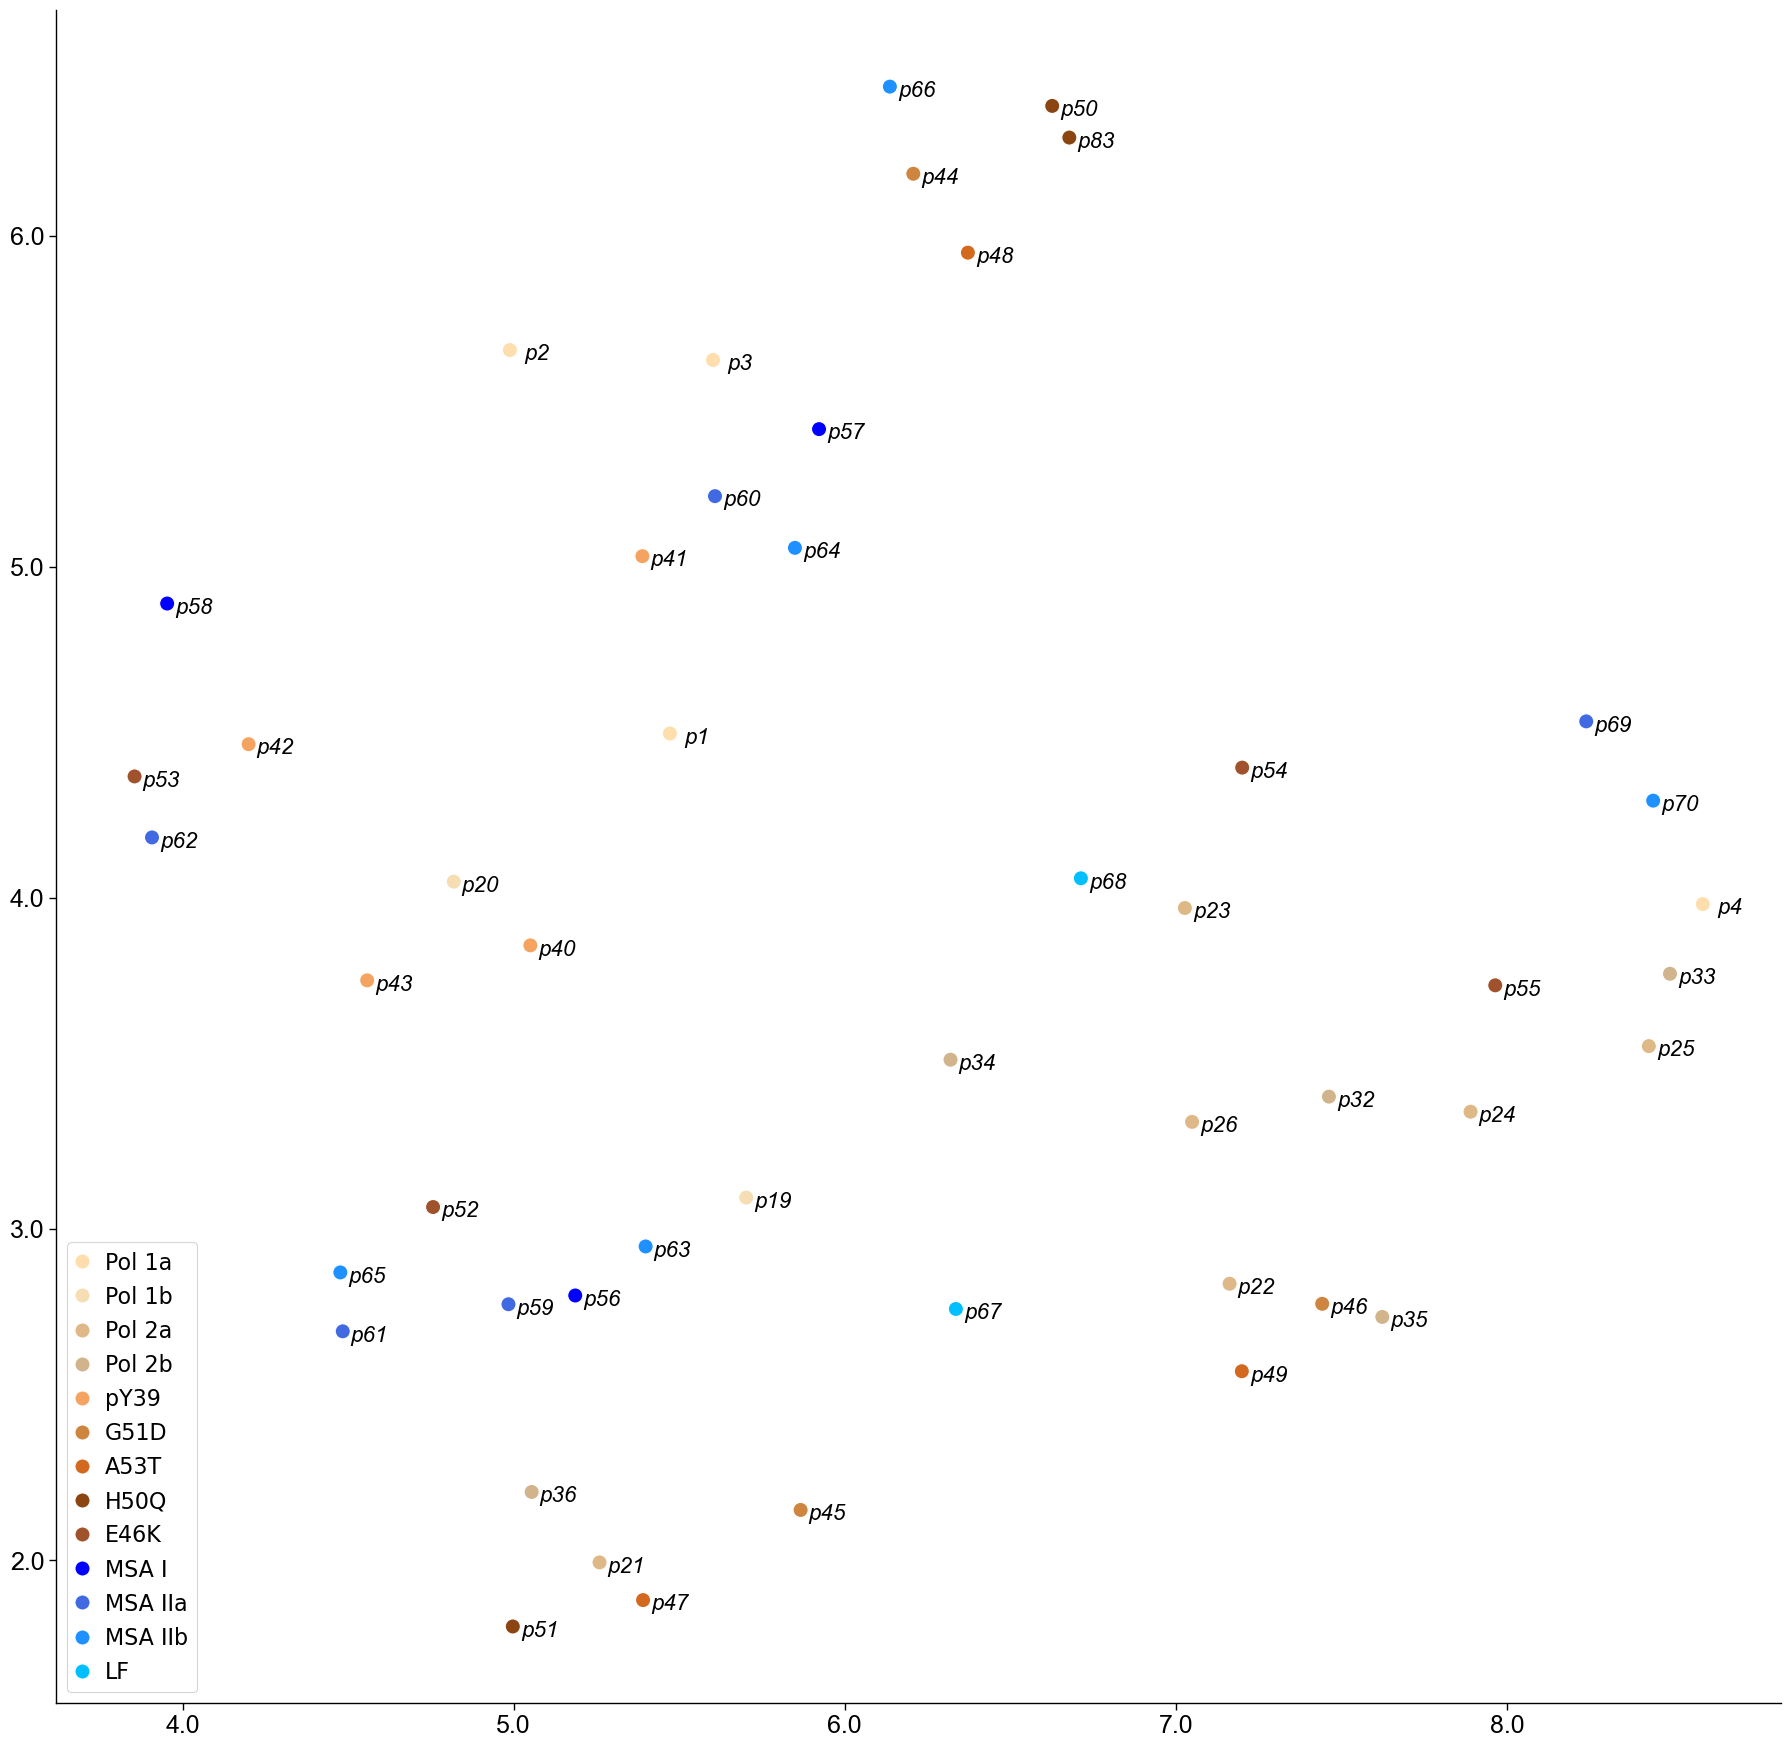

In [245]:
# plot unweighted difference
palette03 = [
    "#FFDEAD", "#F5DEB3", "#DEB887", "#D2B48C", "#F4A460", "#CD853F", "#D2691E", "#8B4513", "#A0522D",
    "#0000FF", "#4169E1", "#1E90FF", "#00BFFF", 
           ]

plot_umap(
    to_plot=results_b2invitro, 
    palette=palette03, 
    output=asyn2invitro_plots_out, 
    ident="aSyn_brain_to_invitro", 
    export=True
    )

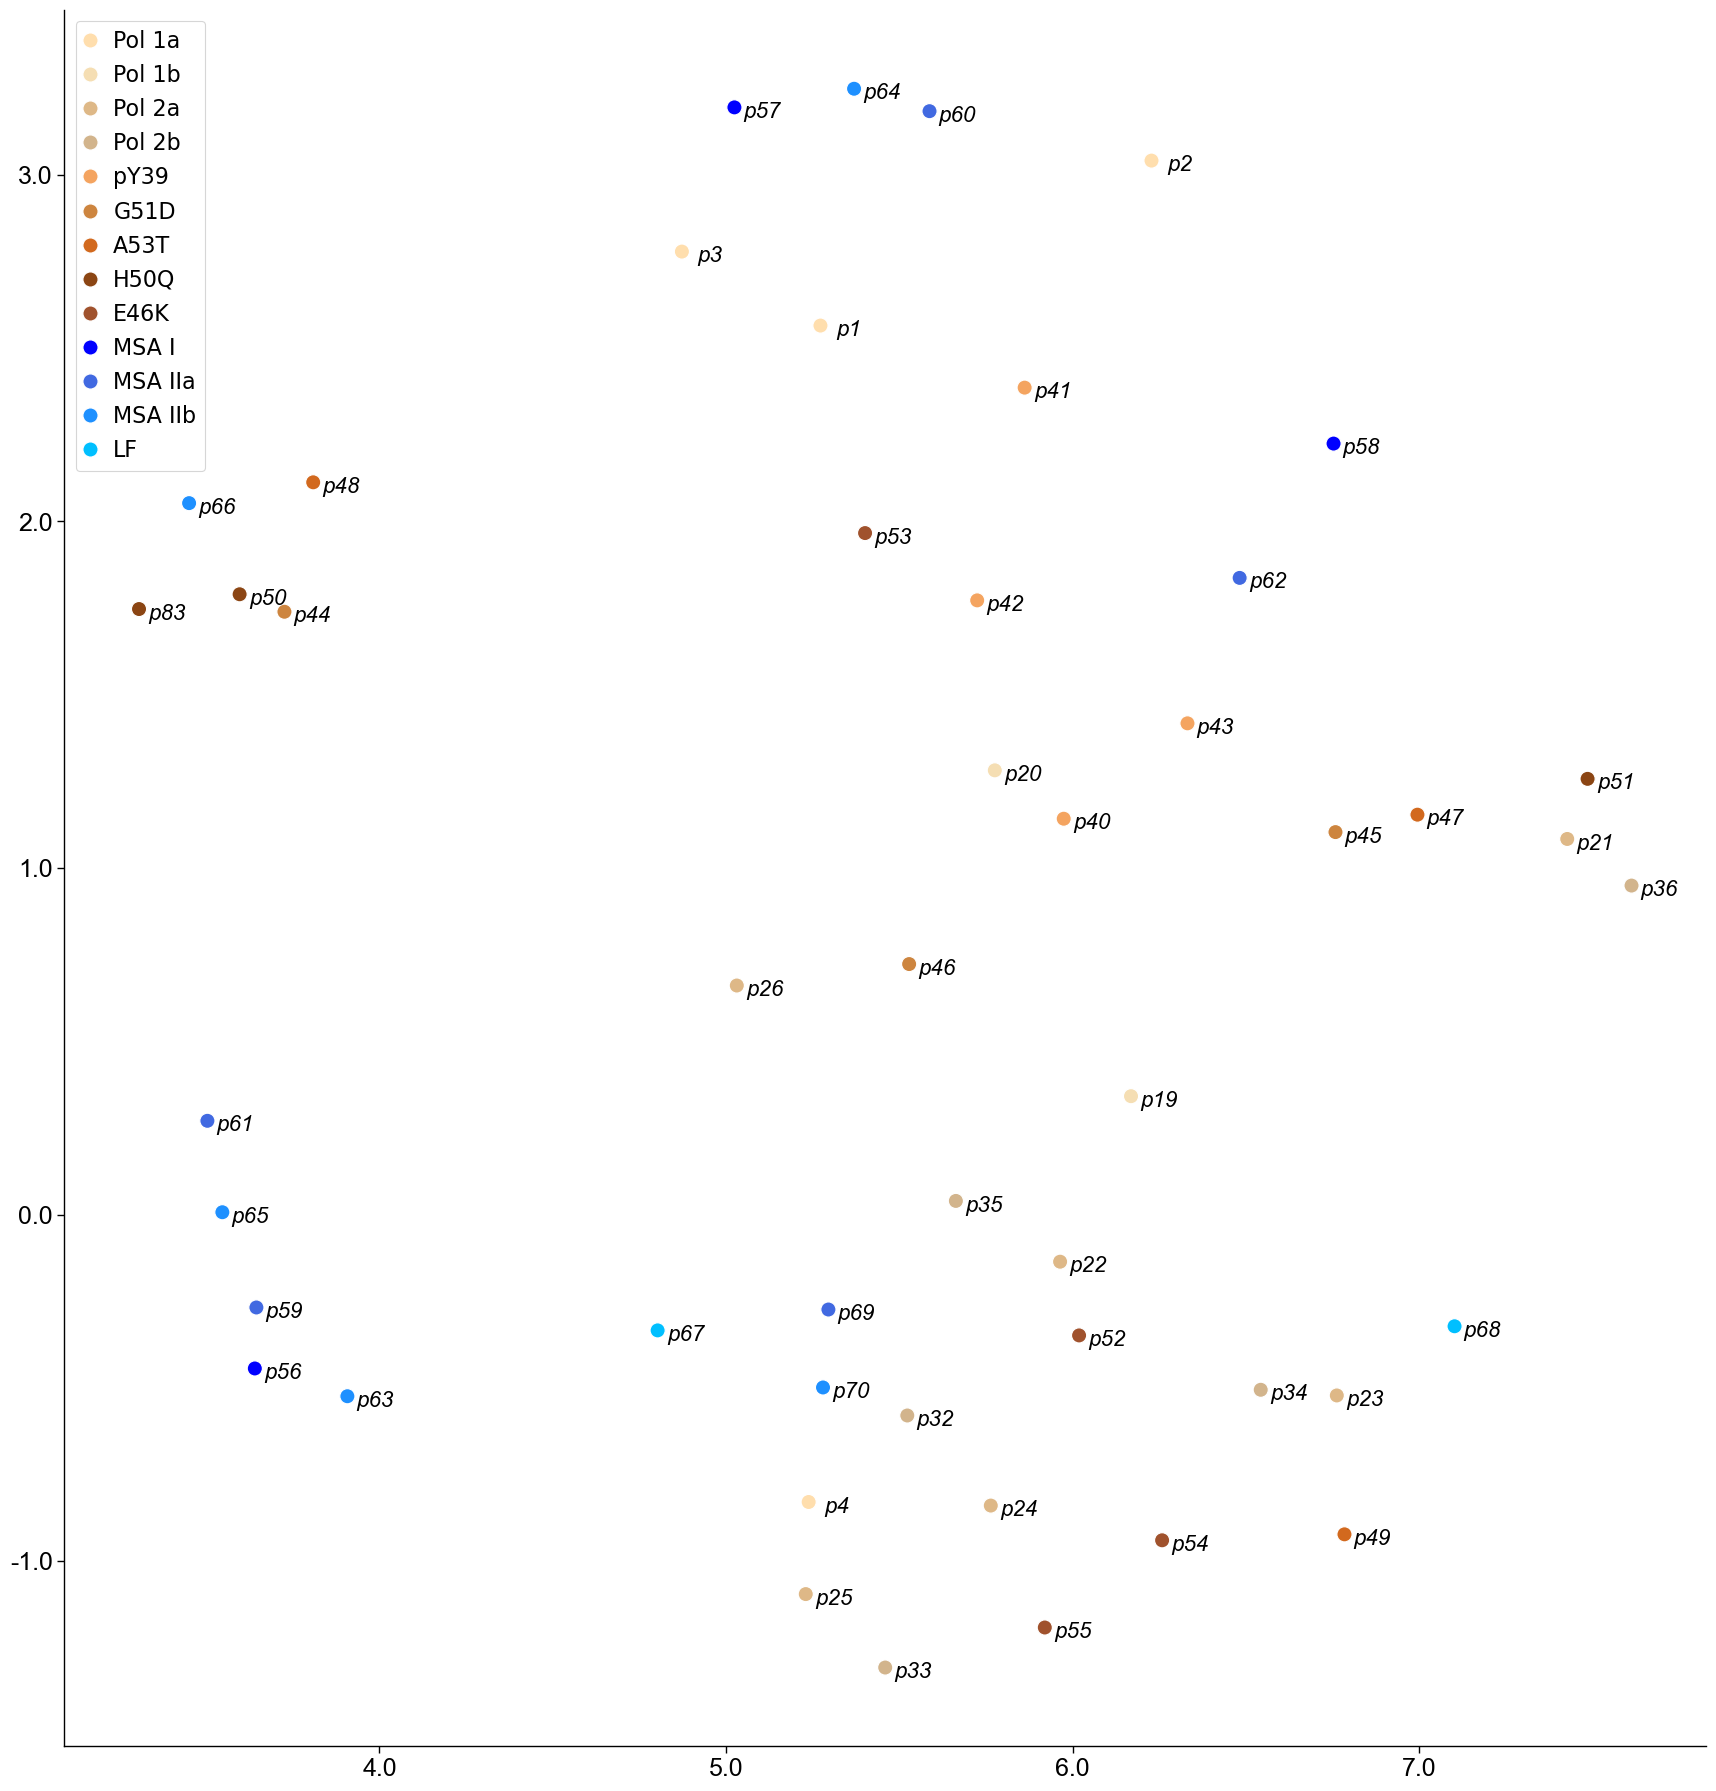

In [246]:
# plot weighted difference
to_plot = copy.deepcopy(results_b2invitro_w)

palette = [
    "#FFDEAD", "#F5DEB3", "#DEB887", "#D2B48C", "#F4A460", "#CD853F", "#D2691E", "#8B4513", "#A0522D",
    "#0000FF", "#4169E1", "#1E90FF", "#00BFFF", 
           ]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=[18,18])

sns.scatterplot(data=to_plot, x = 'projection_x', y = 'projection_y', hue='fibrils', s=120, legend=True, palette=palette)
    
axs.set_xlabel("")
axs.set_ylabel("")

yticks_loc = axs.get_yticks().tolist()
axs.yaxis.set_major_locator(mticker.FixedLocator(yticks_loc))
axs.set_yticklabels(labels=yticks_loc, fontsize=18, fontweight='book', fontfamily='arial')

xticks_loc = axs.get_xticks().tolist()
axs.xaxis.set_major_locator(mticker.FixedLocator(xticks_loc))
axs.set_xticklabels(labels=xticks_loc, fontsize=18, fontweight='book', fontfamily='arial')
    
axs.legend(title="", title_fontsize=10, loc='upper left',  fontsize=16, markerscale=1., handlelength=0.5)

# annotate points
for p, x, y in zip(to_plot["pocket_name"], to_plot['projection_x'], to_plot['projection_y']):
    plt.annotate(text=p.replace('P', 'p'), xy=(x, y), xytext=(x+0.08, y-0.03), ha='center', 
                fontsize=16, fontfamily='arial', fontstyle='oblique', fontweight='book')

# make the figure into a squae
plt.gca().set_aspect('equal', adjustable='box')

sns.set_context("paper")
sns.despine(trim=0)
plt.tight_layout()

plt.savefig(os.path.join(asyn2invitro_plots_out, "aSyn_brain_to_invitro" + '_input_feats_umap_weighted.svg'), format='svg', dpi=300)
plt.savefig(os.path.join(asyn2invitro_plots_out, "aSyn_brain_to_invitro" + '_input_feats_umap_weighted.pdf'), format='pdf', dpi=300)


In [247]:
# container
b2invitro_vessel = []

for poc02 in tqdm(asyn_brain_and_other_invitro_pockets):
    df_temp02 = df_input_b2invitro.copy()[(df_input_b2invitro.source_pocket == poc02) | (df_input_b2invitro.target_pocket == poc02)].sort_values(by="icp_mean_input_diff", ascending=True).reset_index(drop=True).head(5)
    b2invitro_vessel.append(df_temp02)
    df_temp02.to_csv(os.path.join(asyn2invitro_out, poc02 + "_top5_nghs.csv"))

# put the selected nghs into a df
df_b2invitro_sel_ngh = pd.concat(b2invitro_vessel).reset_index(drop=True)
df_b2invitro_sel_ngh.to_csv(os.path.join(asyn2invitro_out, "asyn_brain_to_invitro_top5_nghs.csv"))

100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 284.17it/s]


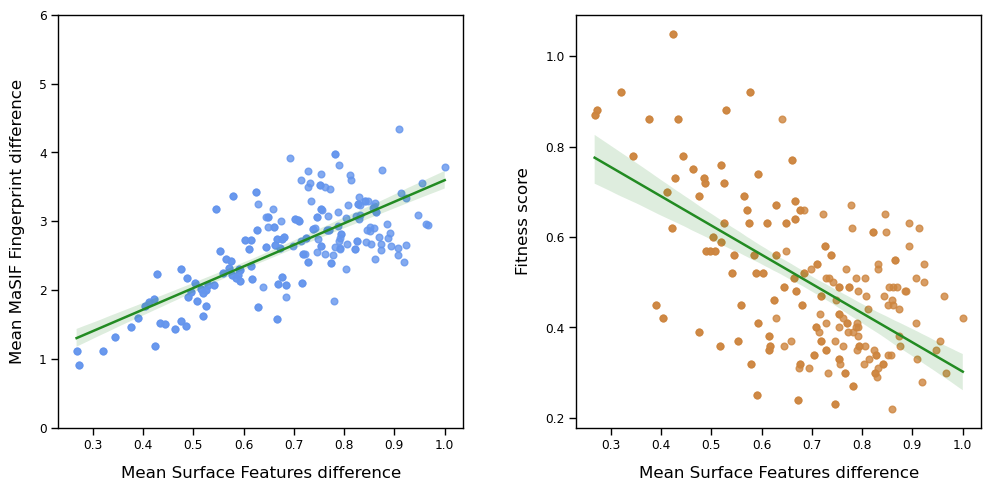

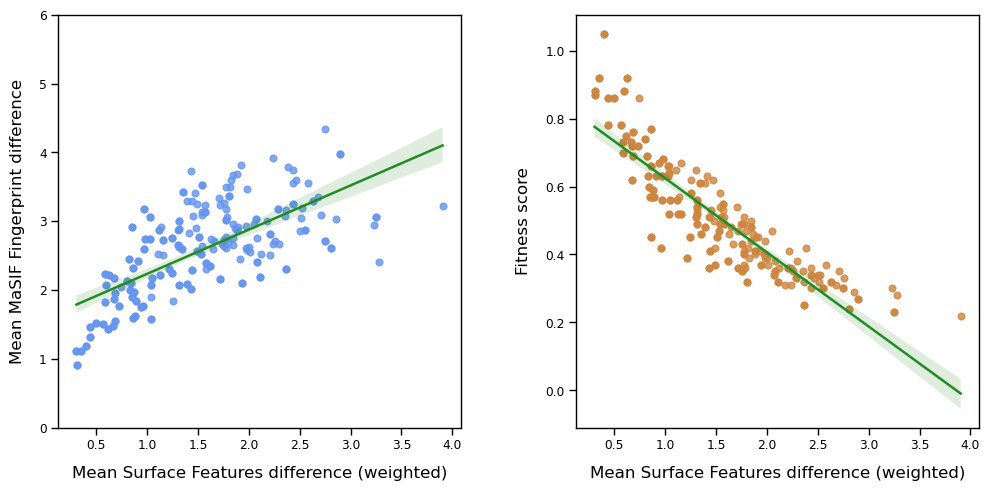

In [248]:
# plot the correlations
plot_input_feat_corr(df=df_b2invitro_sel_ngh, ident="asyn_brain_vs_invitro_selected_nghs",           plots_out=asyn2invitro_plots_out, export=True, show=True, weighted=False)
plot_input_feat_corr(df=df_b2invitro_sel_ngh, ident="asyn_brain_vs_invitro_selected_nghs_weighted",  plots_out=asyn2invitro_plots_out, export=True, show=True, weighted=True)